# Group-F : Project #3 – EDFA profile multi-span prediction

# First Scenario Implementation

# Fatih Temiz
# Ecem Izde Kaya 
# Mobina Mahdavi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from numba import jit
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, confusion_matrix,accuracy_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from typing import List
import argparse
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import random
from sklearn.model_selection import train_test_split
import os
import joblib

In [2]:
first_df=pd.read_csv("Dataset_1.csv")


In [3]:
first_df=first_df.sort_values(by='profileId',ascending=True)
first_df

profileId  measuredTotalPin  measuredTotalPout  inat152782  inat152829  \
9135          2          1.600000               15.0     -17.886     -18.246   
9137          2         -0.046481               15.0     -20.565     -19.365   
9138          2         -1.500000               15.0     -21.498     -20.968   
9139          2         -2.500000               15.0     -22.792     -22.062   
9140          2         -3.500000               15.0     -23.906     -23.046   
...         ...               ...                ...         ...         ...   
9129      19962         -1.500000               15.0     -29.953     -29.083   
9130      19962         -2.700000               15.0     -30.875     -30.065   
9131      19962         -3.800000               15.0     -31.850     -31.360   
9132      19962         -4.700000               15.0     -32.858     -32.898   
9133      19962         -5.500000               15.1     -34.767     -33.887   

      inat152876  inat152923  inat152970  inat153017  inat153064  ...  \
9135     -18.446     -17.766     -17.576     -17.936     -17.836  ...   
9137     -19.905     -19.605     -19.535     -19.635     -19.565  ...   
9138     -21.588     -21.078     -20.948     -21.028     -20.908  ...   
9139     -22.522     -22.082     -21.882     -22.132     -21.922  ...   
9140     -23.506     -23.056     -22.716     -23.116     -23.216  ...   
...          ...         ...         ...         ...         ...  ...   
9129     -29.263     -29.073     -29.313     -29.913     -30.103  ...   
9130     -30.885     -31.385     -31.545     -31.715     -31.575  ...   
9131     -32.720     -32.410     -32.190     -32.420     -32.210  ...   
9132     -33.088     -32.448     -32.178     -32.668     -32.478  ...   
9133     -33.717     -32.997     -33.057     -34.487     -34.557  ...   

      outat156260  outat156307  outat156354  outat156401  outat156448  \
9135       -1.300       -1.350       -1.410       -1.540       -1.610   
9137       -1.764       -1.824       -1.924       -2.094       -2.174   
9138       -1.992       -2.222       -2.222       -2.412       -2.612   
9139       -2.232       -2.402       -2.572       -2.782       -2.932   
9140       -2.455       -2.645       -2.835       -3.165       -3.315   
...           ...          ...          ...          ...          ...   
9129        0.038        0.228        0.608        1.148        1.298   
9130       -0.113        0.037        0.357        0.867        1.217   
9131       -0.219       -0.129        0.101        0.511        0.931   
9132       -0.401       -0.321       -0.031        0.219        0.589   
9133       -0.348       -0.398       -0.258        0.062        0.392   

      outat156495  outat156542  outat156589  outat156636  outat156683  
9135       -1.700       -1.690       -1.800       -1.960       -2.900  
9137       -2.234       -2.324       -2.434       -2.344       -3.354  
9138       -2.712       -2.772       -2.842       -2.722       -3.582  
9139       -3.032       -3.072       -3.182       -3.122       -3.832  
9140       -3.335       -3.415       -3.515       -3.385       -4.045  
...           ...          ...          ...          ...          ...  
9129        1.388        1.118        0.538        0.118       -0.902  
9130        1.327        1.157        0.657        0.177       -1.143  
9131        1.241        1.141        0.621        0.171       -1.329  
9132        1.069        1.089        0.549        0.139       -1.501  
9133        0.842        1.062        0.682        0.152       -1.508  

[16497 rows x 171 columns]

In [4]:
unique_counts = first_df['profileId'].value_counts()

print(unique_counts)



profileId
2        9
13312    9
13284    9
13270    9
13239    9
        ..
6884     9
6872     9
6864     9
6858     9
19962    9
Name: count, Length: 1833, dtype: int64


There is not any NaN value in first dataset

In [5]:
# Check for NaN values in the entire DataFrame
nan_presence = first_df.isna()

# Summarize NaN counts per column
nan_counts = first_df.isna().sum()


print("\nNaN Counts per Column:")
print(nan_counts)
print("total_sum",sum(nan_counts))



NaN Counts per Column:
profileId            0
measuredTotalPin     0
measuredTotalPout    0
inat152782           0
inat152829           0
                    ..
outat156495          0
outat156542          0
outat156589          0
outat156636          0
outat156683          0
Length: 171, dtype: int64
total_sum 0


In [6]:
df=first_df.copy()
def sum_dBm_values(*dBm_values):
    return 10 * np.log10(sum(10**(dBm / 10) for dBm in dBm_values))

df['totalInAt_dBm'] = df[[col for col in df.columns if col.startswith('inat')]].apply(lambda x: sum_dBm_values(*x), axis=1)
df['totalOutAt_dBm'] = df[[col for col in df.columns if col.startswith('outat')]].apply(lambda x: sum_dBm_values(*x), axis=1)

def dbm_to_mw(dbm):
    return 10**(dbm / 10)

df['totalInAt_mW'] = dbm_to_mw(df['totalInAt_dBm'])
df['totalOutAt_mW'] = dbm_to_mw(df['totalOutAt_dBm'])



In [7]:
df

profileId  measuredTotalPin  measuredTotalPout  inat152782  inat152829  \
9135          2          1.600000               15.0     -17.886     -18.246   
9137          2         -0.046481               15.0     -20.565     -19.365   
9138          2         -1.500000               15.0     -21.498     -20.968   
9139          2         -2.500000               15.0     -22.792     -22.062   
9140          2         -3.500000               15.0     -23.906     -23.046   
...         ...               ...                ...         ...         ...   
9129      19962         -1.500000               15.0     -29.953     -29.083   
9130      19962         -2.700000               15.0     -30.875     -30.065   
9131      19962         -3.800000               15.0     -31.850     -31.360   
9132      19962         -4.700000               15.0     -32.858     -32.898   
9133      19962         -5.500000               15.1     -34.767     -33.887   

      inat152876  inat152923  inat152970  inat153017  inat153064  ...  \
9135     -18.446     -17.766     -17.576     -17.936     -17.836  ...   
9137     -19.905     -19.605     -19.535     -19.635     -19.565  ...   
9138     -21.588     -21.078     -20.948     -21.028     -20.908  ...   
9139     -22.522     -22.082     -21.882     -22.132     -21.922  ...   
9140     -23.506     -23.056     -22.716     -23.116     -23.216  ...   
...          ...         ...         ...         ...         ...  ...   
9129     -29.263     -29.073     -29.313     -29.913     -30.103  ...   
9130     -30.885     -31.385     -31.545     -31.715     -31.575  ...   
9131     -32.720     -32.410     -32.190     -32.420     -32.210  ...   
9132     -33.088     -32.448     -32.178     -32.668     -32.478  ...   
9133     -33.717     -32.997     -33.057     -34.487     -34.557  ...   

      outat156448  outat156495  outat156542  outat156589  outat156636  \
9135       -1.610       -1.700       -1.690       -1.800       -1.960   
9137       -2.174       -2.234       -2.324       -2.434       -2.344   
9138       -2.612       -2.712       -2.772       -2.842       -2.722   
9139       -2.932       -3.032       -3.072       -3.182       -3.122   
9140       -3.315       -3.335       -3.415       -3.515       -3.385   
...           ...          ...          ...          ...          ...   
9129        1.298        1.388        1.118        0.538        0.118   
9130        1.217        1.327        1.157        0.657        0.177   
9131        0.931        1.241        1.141        0.621        0.171   
9132        0.589        1.069        1.089        0.549        0.139   
9133        0.392        0.842        1.062        0.682        0.152   

      outat156683  totalInAt_dBm  totalOutAt_dBm  totalInAt_mW  totalOutAt_mW  
9135       -2.900       1.599475       14.999250      1.445265      31.617318  
9137       -3.354      -0.047694       14.999007      0.989078      31.615550  
9138       -3.582      -1.501270       14.998756      0.707739      31.613720  
9139       -3.832      -2.500570       14.998586      0.562267      31.612482  
9140       -4.045      -3.501342       14.998493      0.446546      31.611806  
...           ...            ...             ...           ...            ...  
9129       -0.902      -1.502024       14.998760      0.707616      31.613752  
9130       -1.143      -2.702076       14.997986      0.536775      31.608114  
9131       -1.329      -3.801952       14.998107      0.416682      31.608999  
9132       -1.501      -4.702354       14.998515      0.338661      31.611963  
9133       -1.508      -5.502226       15.098026      0.281694      32.344657  

[16497 rows x 175 columns]

In [8]:
df.describe()

profileId  measuredTotalPin  measuredTotalPout    inat152782  \
count  16497.000000      16497.000000       16497.000000  16497.000000   
mean   10072.219858         -2.406354          14.995927    -23.070990   
std     5678.698035          2.684093           0.032633      4.044395   
min        2.000000         -7.100000          14.900000    -41.275000   
25%     5273.000000         -4.700000          15.000000    -25.595000   
50%    10093.000000         -2.600000          15.000000    -22.919000   
75%    14727.000000         -0.046481          15.000000    -20.329000   
max    19962.000000          2.300000          15.100000    -11.064000   

         inat152829    inat152876    inat152923    inat152970    inat153017  \
count  16497.000000  16497.000000  16497.000000  16497.000000  16497.000000   
mean     -22.560116    -22.939042    -22.632351    -22.538749    -22.784246   
std        3.971898      4.066285      4.159066      4.121255      4.284177   
min      -39.945000    -41.517000    -42.457000    -42.337000    -45.784000   
25%      -24.914000    -25.638000    -25.411000    -25.205000    -25.378000   
50%      -22.458000    -22.772000    -22.342000    -22.197000    -22.383000   
75%      -19.521000    -19.820000    -19.568000    -19.534000    -19.602000   
max      -11.025000    -11.594000    -11.844000    -11.884000    -12.151000   

         inat153064  ...   outat156448   outat156495   outat156542  \
count  16497.000000  ...  16497.000000  16497.000000  16497.000000   
mean     -22.715920  ...     -3.114206     -3.179204     -3.257982   
std        4.248321  ...      2.366063      2.478067      2.569034   
min      -42.834000  ...    -13.529000    -13.098000    -14.708000   
25%      -25.328000  ...     -4.279000     -4.438000     -4.614000   
50%      -22.324000  ...     -2.967000     -3.055000     -3.097000   
75%      -19.529000  ...     -1.718000     -1.683000     -1.606000   
max      -11.830000  ...      3.067000      3.111000      2.991000   

        outat156589   outat156636   outat156683  totalInAt_dBm  \
count  16497.000000  16497.000000  16497.000000   16497.000000   
mean      -3.463035     -3.504718     -4.629408      -2.407325   
std        2.608171      2.556375      2.405698       2.684328   
min      -14.448000    -15.176000    -15.947000      -7.102517   
25%       -4.840000     -4.734000     -5.607000      -4.700356   
50%       -3.189000     -3.089000     -4.246000      -2.600591   
75%       -1.683000     -1.780000     -3.206000      -0.046951   
max        2.711000      2.626000      2.066000       2.299561   

       totalOutAt_dBm  totalInAt_mW  totalOutAt_mW  
count    16497.000000  16497.000000   16497.000000  
mean        14.994407      0.691311      31.582960  
std          0.032480      0.411856       0.235522  
min         14.898116      0.194871      30.889554  
25%         14.998060      0.338816      31.608651  
50%         14.998467      0.549466      31.611619  
75%         14.998813      0.989247      31.614135  
max         15.099420      1.698072      32.355043  

[8 rows x 175 columns]

In [9]:
# Plotting histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['measuredTotalPin'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Measured Total Pin')
plt.xlabel('Measured Total Pin')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['measuredTotalPout'], bins=30, color='red', alpha=0.7)
plt.title('Histogram of Measured Total Pout')
plt.xlabel('Measured Total Pout')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

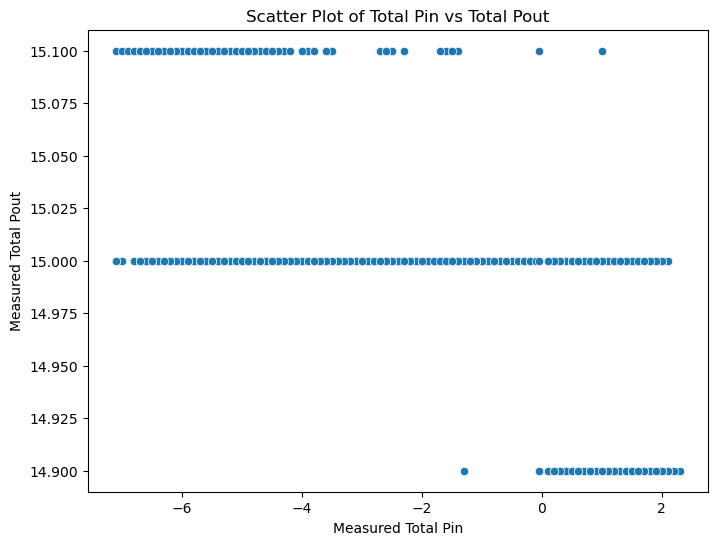

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='measuredTotalPin', y='measuredTotalPout', data=df)
plt.title('Scatter Plot of Total Pin vs Total Pout')
plt.xlabel('Measured Total Pin')
plt.ylabel('Measured Total Pout')
plt.show()

In [11]:
selected_df_output_pwr = df.iloc[:, list(range(87, 171))]
selected_df_input_pwr=df.iloc[:,3:87]

In [12]:
selected_df_output_pwr

outat152782  outat152829  outat152876  outat152923  outat152970  \
9135      -15.530      -15.410      -15.200      -14.130      -13.510   
9137      -14.644      -13.024      -13.124      -12.274      -11.974   
9138      -12.932      -11.862      -12.232      -11.012      -10.802   
9139      -12.332      -11.212      -11.422      -10.292      -10.022   
9140      -11.705      -10.445      -10.705       -9.645       -9.135   
...           ...          ...          ...          ...          ...   
9129      -23.402      -22.242      -21.932      -21.382      -21.212   
9130      -22.013      -20.933      -21.203      -21.323      -21.003   
9131      -20.839      -19.959      -20.879      -20.049      -19.629   
9132      -19.951      -19.551      -19.241      -18.131      -17.541   
9133      -19.768      -18.448      -17.718      -16.788      -16.338   

      outat153017  outat153064  outat153111  outat153158  outat153205  ...  \
9135      -13.490      -13.020      -12.690      -12.410      -11.750  ...   
9137      -11.674      -11.244      -10.944      -10.704      -10.144  ...   
9138      -10.412       -9.982       -9.892       -9.722       -9.122  ...   
9139       -9.782       -9.272       -9.012       -8.942       -8.502  ...   
9140       -9.175       -8.955       -9.005       -8.865       -8.335  ...   
...           ...          ...          ...          ...          ...  ...   
9129      -21.412      -21.222      -20.752      -20.402      -19.392  ...   
9130      -20.913      -20.403      -20.163      -19.773      -18.953  ...   
9131      -19.409      -18.839      -18.869      -18.249      -17.179  ...   
9132      -17.771      -17.221      -17.401      -16.801      -15.371  ...   
9133      -17.498      -17.198      -17.138      -17.528      -16.368  ...   

      outat156260  outat156307  outat156354  outat156401  outat156448  \
9135       -1.300       -1.350       -1.410       -1.540       -1.610   
9137       -1.764       -1.824       -1.924       -2.094       -2.174   
9138       -1.992       -2.222       -2.222       -2.412       -2.612   
9139       -2.232       -2.402       -2.572       -2.782       -2.932   
9140       -2.455       -2.645       -2.835       -3.165       -3.315   
...           ...          ...          ...          ...          ...   
9129        0.038        0.228        0.608        1.148        1.298   
9130       -0.113        0.037        0.357        0.867        1.217   
9131       -0.219       -0.129        0.101        0.511        0.931   
9132       -0.401       -0.321       -0.031        0.219        0.589   
9133       -0.348       -0.398       -0.258        0.062        0.392   

      outat156495  outat156542  outat156589  outat156636  outat156683  
9135       -1.700       -1.690       -1.800       -1.960       -2.900  
9137       -2.234       -2.324       -2.434       -2.344       -3.354  
9138       -2.712       -2.772       -2.842       -2.722       -3.582  
9139       -3.032       -3.072       -3.182       -3.122       -3.832  
9140       -3.335       -3.415       -3.515       -3.385       -4.045  
...           ...          ...          ...          ...          ...  
9129        1.388        1.118        0.538        0.118       -0.902  
9130        1.327        1.157        0.657        0.177       -1.143  
9131        1.241        1.141        0.621        0.171       -1.329  
9132        1.069        1.089        0.549        0.139       -1.501  
9133        0.842        1.062        0.682        0.152       -1.508  

[16497 rows x 84 columns]

In [13]:
selected_df_input_pwr

inat152782  inat152829  inat152876  inat152923  inat152970  inat153017  \
9135     -17.886     -18.246     -18.446     -17.766     -17.576     -17.936   
9137     -20.565     -19.365     -19.905     -19.605     -19.535     -19.635   
9138     -21.498     -20.968     -21.588     -21.078     -20.948     -21.028   
9139     -22.792     -22.062     -22.522     -22.082     -21.882     -22.132   
9140     -23.906     -23.046     -23.506     -23.056     -22.716     -23.116   
...          ...         ...         ...         ...         ...         ...   
9129     -29.953     -29.083     -29.263     -29.073     -29.313     -29.913   
9130     -30.875     -30.065     -30.885     -31.385     -31.545     -31.715   
9131     -31.850     -31.360     -32.720     -32.410     -32.190     -32.420   
9132     -32.858     -32.898     -33.088     -32.448     -32.178     -32.668   
9133     -34.767     -33.887     -33.717     -32.997     -33.057     -34.487   

      inat153064  inat153111  inat153158  inat153205  ...  inat156260  \
9135     -17.836     -17.866     -17.916     -17.736  ...     -17.386   
9137     -19.565     -19.605     -19.525     -19.375  ...     -19.215   
9138     -20.908     -21.058     -21.078     -20.808  ...     -20.638   
9139     -21.922     -21.902     -21.932     -21.762  ...     -21.682   
9140     -23.216     -23.446     -23.426     -23.196  ...     -22.676   
...          ...         ...         ...         ...  ...         ...   
9129     -30.103     -29.983     -29.813     -29.133  ...     -17.393   
9130     -31.575     -31.545     -31.395     -30.805  ...     -18.625   
9131     -32.210     -32.420     -32.040     -31.010  ...     -19.710   
9132     -32.478     -32.848     -32.448     -31.058  ...     -20.758   
9133     -34.557     -34.547     -35.257     -33.937  ...     -21.617   

      inat156307  inat156354  inat156401  inat156448  inat156495  inat156542  \
9135     -17.266     -17.176     -17.116     -17.016     -16.916     -16.686   
9137     -19.125     -19.035     -18.995     -18.845     -18.705     -18.545   
9138     -20.608     -20.498     -20.448     -20.368     -20.228     -20.038   
9139     -21.582     -21.592     -21.522     -21.422     -21.282     -21.052   
9140     -22.556     -22.606     -22.586     -22.506     -22.316     -22.056   
...          ...         ...         ...         ...         ...         ...   
9129     -17.043     -16.483     -15.763     -15.353     -15.063     -15.093   
9130     -18.295     -17.755     -17.025     -16.465     -16.075     -15.995   
9131     -19.400     -18.940     -18.290     -17.690     -17.100     -16.940   
9132     -20.478     -19.998     -19.478     -18.808     -18.098     -17.778   
9133     -21.347     -20.977     -20.407     -19.817     -19.077     -18.517   

      inat156589  inat156636  inat156683  
9135     -16.576     -16.506     -16.616  
9137     -18.395     -18.065     -18.225  
9138     -19.818     -19.448     -19.368  
9139     -20.852     -20.512     -20.262  
9140     -21.876     -21.436     -21.126  
...          ...         ...         ...  
9129     -15.373     -15.563     -15.633  
9130     -16.215     -16.405     -16.735  
9131     -17.130     -17.270     -17.750  
9132     -17.948     -18.058     -18.628  
9133     -18.557     -18.717     -19.357  

[16497 rows x 84 columns]

# Below heatmaps of input and output power profiles have shown. It is obvious that non-adjacent channels do not correlate

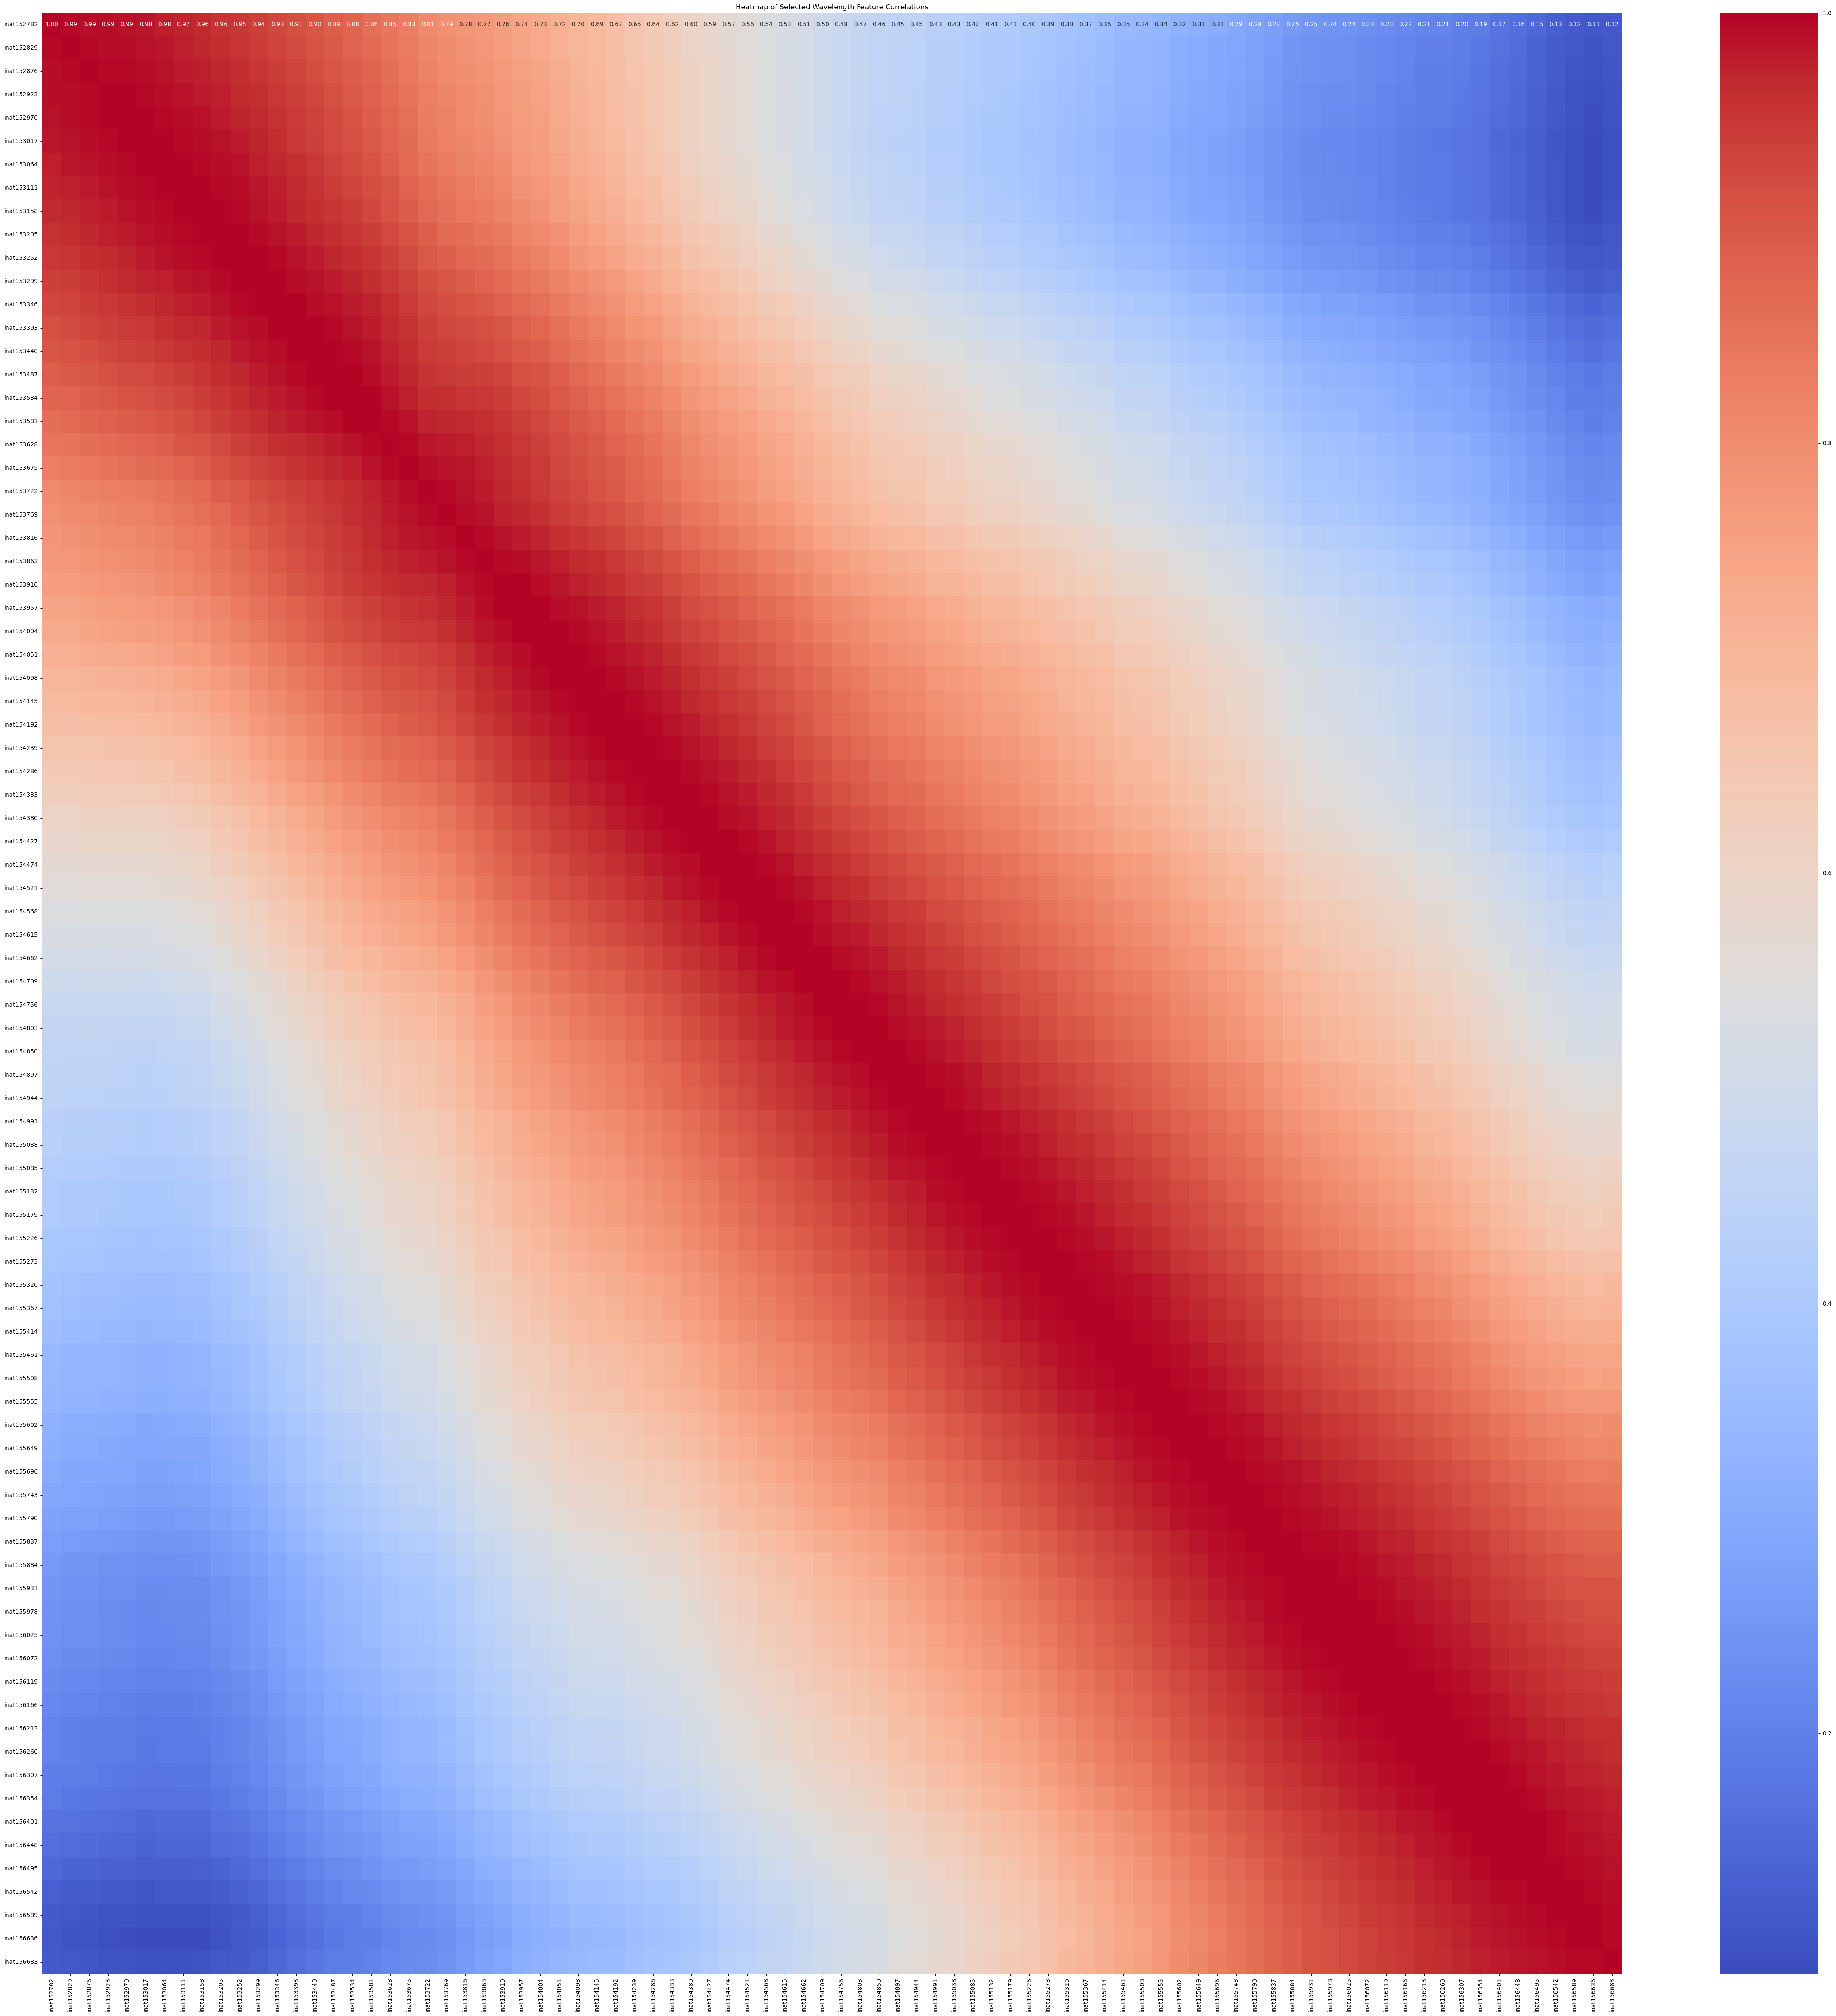

In [14]:
subset=selected_df_input_pwr

# Calculate correlation matrix
corr_matrix = subset.corr()

# Plotting the heatmap
plt.figure(figsize=(60, 60))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Selected Wavelength Feature Correlations')
plt.show()

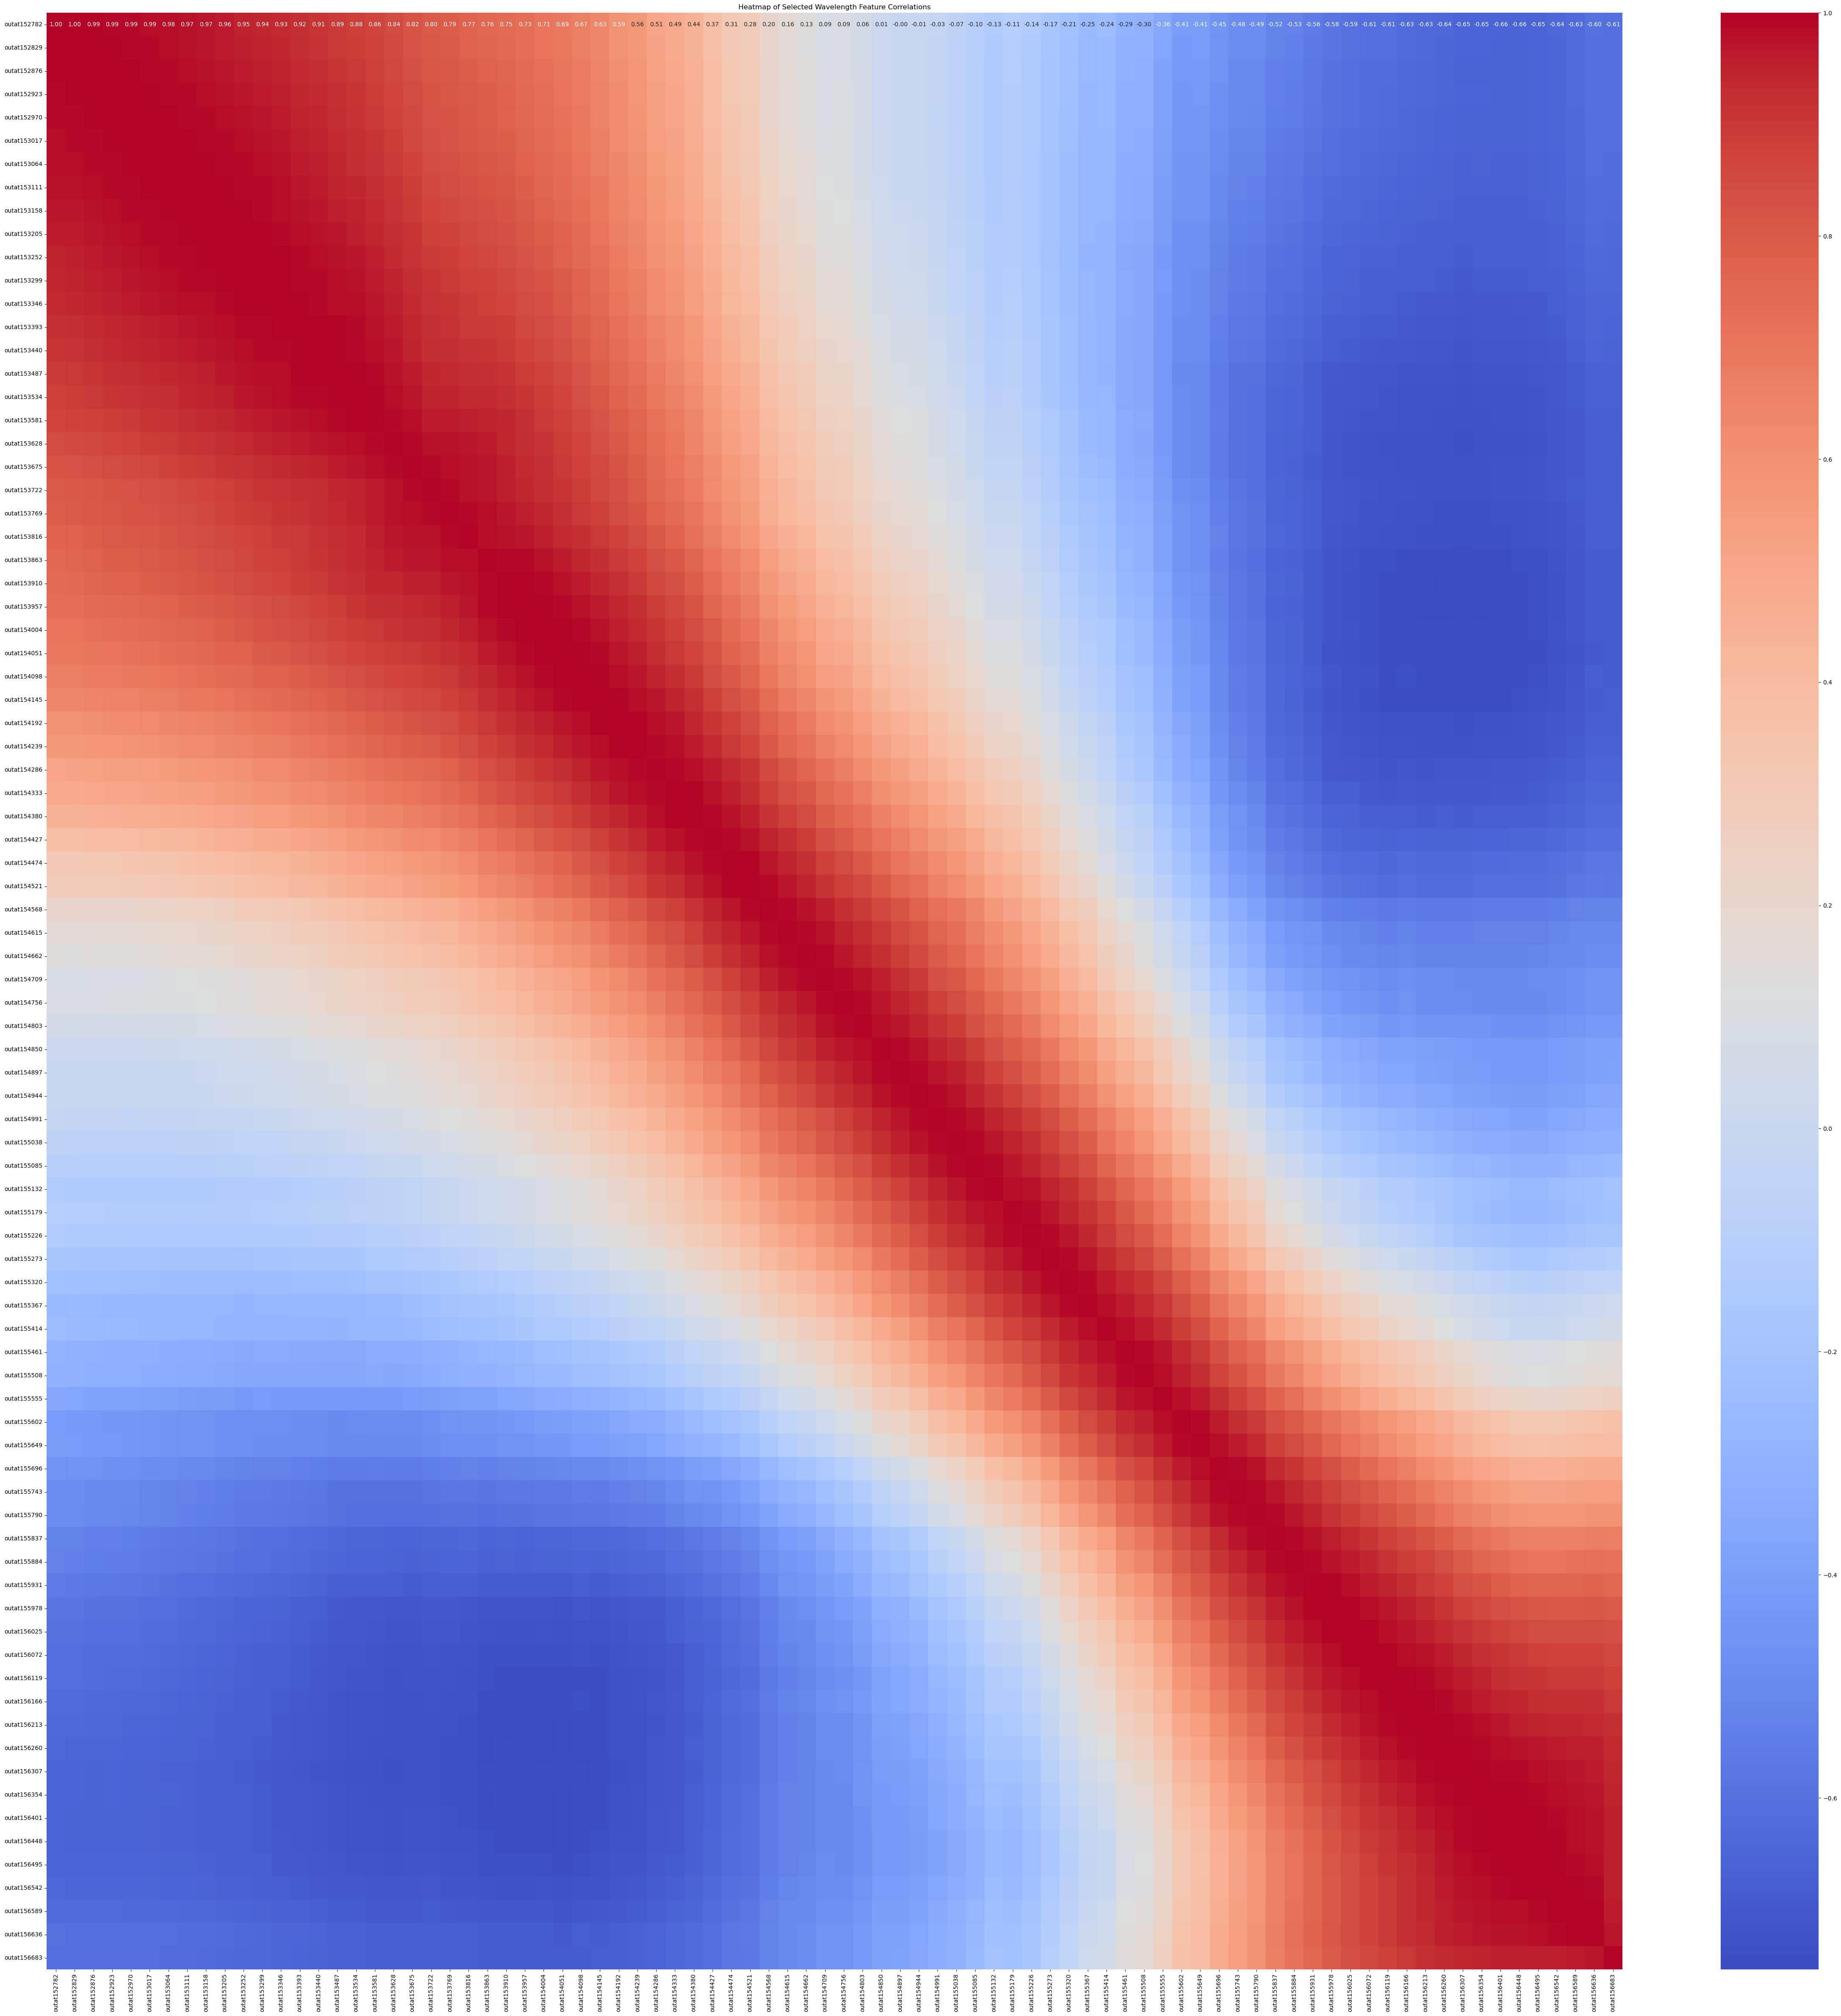

In [15]:
subset=selected_df_output_pwr

# Calculate correlation matrix
corr_matrix = subset.corr()

# Plotting the heatmap
plt.figure(figsize=(60, 60))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Selected Wavelength Feature Correlations')
plt.show()

# Neural Network Model 

In [27]:
class CentralizedModel(nn.Module):
    def __init__(self, input_dim=86, hidden_units=[256,128], num_classes=84):
        super(CentralizedModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_units[0])
        hidden_layers = []
        for i in range(1, len(hidden_units)):
            hidden_layers.append(nn.Linear(hidden_units[i - 1], hidden_units[i]))
            hidden_layers.append(nn.ReLU())
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Linear(hidden_units[-1], num_classes)
        
        # Initialize weights using He initialization
        #self.init_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
    
    
    
    '''
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    '''

In [29]:
df

profileId  measuredTotalPin  measuredTotalPout  inat152782  inat152829  \
9135          2          1.600000               15.0     -17.886     -18.246   
9137          2         -0.046481               15.0     -20.565     -19.365   
9138          2         -1.500000               15.0     -21.498     -20.968   
9139          2         -2.500000               15.0     -22.792     -22.062   
9140          2         -3.500000               15.0     -23.906     -23.046   
...         ...               ...                ...         ...         ...   
9129      19962         -1.500000               15.0     -29.953     -29.083   
9130      19962         -2.700000               15.0     -30.875     -30.065   
9131      19962         -3.800000               15.0     -31.850     -31.360   
9132      19962         -4.700000               15.0     -32.858     -32.898   
9133      19962         -5.500000               15.1     -34.767     -33.887   

      inat152876  inat152923  inat152970  inat153017  inat153064  ...  \
9135     -18.446     -17.766     -17.576     -17.936     -17.836  ...   
9137     -19.905     -19.605     -19.535     -19.635     -19.565  ...   
9138     -21.588     -21.078     -20.948     -21.028     -20.908  ...   
9139     -22.522     -22.082     -21.882     -22.132     -21.922  ...   
9140     -23.506     -23.056     -22.716     -23.116     -23.216  ...   
...          ...         ...         ...         ...         ...  ...   
9129     -29.263     -29.073     -29.313     -29.913     -30.103  ...   
9130     -30.885     -31.385     -31.545     -31.715     -31.575  ...   
9131     -32.720     -32.410     -32.190     -32.420     -32.210  ...   
9132     -33.088     -32.448     -32.178     -32.668     -32.478  ...   
9133     -33.717     -32.997     -33.057     -34.487     -34.557  ...   

      outat156448  outat156495  outat156542  outat156589  outat156636  \
9135       -1.610       -1.700       -1.690       -1.800       -1.960   
9137       -2.174       -2.234       -2.324       -2.434       -2.344   
9138       -2.612       -2.712       -2.772       -2.842       -2.722   
9139       -2.932       -3.032       -3.072       -3.182       -3.122   
9140       -3.315       -3.335       -3.415       -3.515       -3.385   
...           ...          ...          ...          ...          ...   
9129        1.298        1.388        1.118        0.538        0.118   
9130        1.217        1.327        1.157        0.657        0.177   
9131        0.931        1.241        1.141        0.621        0.171   
9132        0.589        1.069        1.089        0.549        0.139   
9133        0.392        0.842        1.062        0.682        0.152   

      outat156683  totalInAt_dBm  totalOutAt_dBm  totalInAt_mW  totalOutAt_mW  
9135       -2.900       1.599475       14.999250      1.445265      31.617318  
9137       -3.354      -0.047694       14.999007      0.989078      31.615550  
9138       -3.582      -1.501270       14.998756      0.707739      31.613720  
9139       -3.832      -2.500570       14.998586      0.562267      31.612482  
9140       -4.045      -3.501342       14.998493      0.446546      31.611806  
...           ...            ...             ...           ...            ...  
9129       -0.902      -1.502024       14.998760      0.707616      31.613752  
9130       -1.143      -2.702076       14.997986      0.536775      31.608114  
9131       -1.329      -3.801952       14.998107      0.416682      31.608999  
9132       -1.501      -4.702354       14.998515      0.338661      31.611963  
9133       -1.508      -5.502226       15.098026      0.281694      32.344657  

[16497 rows x 175 columns]

In [31]:
'''
power_profile_columns = df.columns[1:171]
input_columns = df.columns[1:87]
output_columns = df.columns[87:-4]

# Initialize separate scalers for inputs and outputs
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale the entire dataset first
df[power_profile_columns] = scaler_X.fit_transform(df[power_profile_columns])
joblib.dump(scaler_X, 'scaler_X.pkl')  # Save the scaler for inputs
'''

input_columns = df.columns[1:87]
output_columns = df.columns[87:-4]
print(input_columns,output_columns)
X=df[input_columns]
y=df[output_columns]

'''
grouped = df.groupby('profileId')

X_train, y_train, X_test, y_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for _, group in grouped:
    shuffled_group = group.sample(frac=1, random_state=42)
    train, test = shuffled_group.iloc[:7], shuffled_group.iloc[7:9]

    X_train = pd.concat([X_train, train[input_columns]], ignore_index=True)
    y_train = pd.concat([y_train, train[output_columns]], ignore_index=True)
    X_test = pd.concat([X_test, test[input_columns]], ignore_index=True)
    y_test = pd.concat([y_test, test[output_columns]], ignore_index=True)
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)
    
scaler_X_standard = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled=scaler_X_standard.fit_transform(X_train)
X_test_scaled=scaler_X_standard.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving scalers for later use
joblib.dump(scaler_X_standard, 'scaler_X_standard_dataset_first.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')


# Convert DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create Datasets and DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)




Index(['measuredTotalPin', 'measuredTotalPout', 'inat152782', 'inat152829',
       'inat152876', 'inat152923', 'inat152970', 'inat153017', 'inat153064',
       'inat153111', 'inat153158', 'inat153205', 'inat153252', 'inat153299',
       'inat153346', 'inat153393', 'inat153440', 'inat153487', 'inat153534',
       'inat153581', 'inat153628', 'inat153675', 'inat153722', 'inat153769',
       'inat153816', 'inat153863', 'inat153910', 'inat153957', 'inat154004',
       'inat154051', 'inat154098', 'inat154145', 'inat154192', 'inat154239',
       'inat154286', 'inat154333', 'inat154380', 'inat154427', 'inat154474',
       'inat154521', 'inat154568', 'inat154615', 'inat154662', 'inat154709',
       'inat154756', 'inat154803', 'inat154850', 'inat154897', 'inat154944',
       'inat154991', 'inat155038', 'inat155085', 'inat155132', 'inat155179',
       'inat155226', 'inat155273', 'inat155320', 'inat155367', 'inat155414',
       'inat155461', 'inat155508', 'inat155555', 'inat155602', 'inat155649',


In [33]:
X_train_scaled_df=pd.DataFrame(X_train_scaled)
X_train_scaled_df.hist

<bound method hist_frame of              0         1         2         3         4         5         6   \
0      0.406872  0.123197  0.177355  0.260406  0.261785  0.359889  0.425337   
1     -0.371848  0.123197 -0.596432 -0.575012 -0.747027 -0.712766 -0.790051   
2     -0.075193  0.123197  0.147006  0.159181  0.106640  0.198608  0.185210   
3      1.185593 -2.929210  0.777681  0.929293  0.983100  1.005256  0.994340   
4     -1.595552  0.123197 -0.763724 -0.888482 -0.837222 -0.939950 -0.869368   
...         ...       ...       ...       ...       ...       ...       ...   
12532  1.222675 -2.929210  0.125292 -0.006094  0.067915  0.074471  0.055111   
12533 -0.075193  0.123197  0.708840  0.726090  0.841190  0.753867  0.786617   
12534 -0.334766  0.123197 -0.641339 -0.610679 -0.495069 -0.655730 -0.519696   
12535 -0.742668  0.123197  0.530198  0.408601  0.477469  0.403026  0.466447   
12536 -0.334766  0.123197 -0.271964 -0.237178 -0.240905 -0.174761 -0.210892   

             7         

In [35]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(12537, 86) (12537, 84) (3960, 86) (3960, 84)


# Training single EDFA Model 

In [37]:
# Initialize the model, loss function, and optimizer
model = CentralizedModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        model.train()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.0381
Epoch [2/50], Loss: 0.0148
Epoch [3/50], Loss: 0.0126
Epoch [4/50], Loss: 0.0109
Epoch [5/50], Loss: 0.0074
Epoch [6/50], Loss: 0.0068
Epoch [7/50], Loss: 0.0069
Epoch [8/50], Loss: 0.0058
Epoch [9/50], Loss: 0.0055
Epoch [10/50], Loss: 0.0059
Epoch [11/50], Loss: 0.0050
Epoch [12/50], Loss: 0.0050
Epoch [13/50], Loss: 0.0045
Epoch [14/50], Loss: 0.0040
Epoch [15/50], Loss: 0.0042
Epoch [16/50], Loss: 0.0038
Epoch [17/50], Loss: 0.0045
Epoch [18/50], Loss: 0.0038
Epoch [19/50], Loss: 0.0033
Epoch [20/50], Loss: 0.0028
Epoch [21/50], Loss: 0.0057
Epoch [22/50], Loss: 0.0035
Epoch [23/50], Loss: 0.0028
Epoch [24/50], Loss: 0.0030
Epoch [25/50], Loss: 0.0035
Epoch [26/50], Loss: 0.0038
Epoch [27/50], Loss: 0.0043
Epoch [28/50], Loss: 0.0033
Epoch [29/50], Loss: 0.0032
Epoch [30/50], Loss: 0.0030
Epoch [31/50], Loss: 0.0027
Epoch [32/50], Loss: 0.0030
Epoch [33/50], Loss: 0.0032
Epoch [34/50], Loss: 0.0033
Epoch [35/50], Loss: 0.0034
Epoch [36/50], Loss: 0.0066
E

In [44]:
def test_and_rescale(model, test_loader, scaler_y, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  # No need to track gradients
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_predictions.append(outputs)
            all_targets.append(targets)
    
    # Concatenate all batches
    predictions_scaled = torch.cat(all_predictions).cpu().numpy()
    targets_scaled = torch.cat(all_targets).cpu().numpy()
    
    # Rescale predictions and targets to original scale
    predictions = scaler_y.inverse_transform(predictions_scaled)
    targets = scaler_y.inverse_transform(targets_scaled)
    
    # Calculate average loss and potentially other metrics
    average_loss = total_loss / len(test_loader)
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)  # Calculate MAE

    return average_loss, mse, mae,predictions, targets


scaler_y = joblib.load('scaler_y.pkl')

# Evaluate the model and rescale predictions
test_loss, mse,mae, predictions, actuals = test_and_rescale(model, test_loader, scaler_y, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


Test Loss: 0.0026
Mean Squared Error: 0.0115
Mean Absolute Error: 0.0728


In [45]:
outputs_rescaled_df=pd.DataFrame(predictions)
targets_rescaled_df=pd.DataFrame(actuals)

In [46]:
outputs_rescaled_df

0          1          2          3          4          5   \
0     -4.166483  -3.655587  -3.151345  -2.331981  -1.797568  -1.989925   
1     -2.324008  -1.019524  -2.215571  -1.039328  -0.372649  -0.577865   
2    -10.579729  -9.723196 -10.081922  -8.876651  -8.605812  -8.527962   
3    -16.596083 -15.564116 -14.928519 -14.636680 -13.876913 -13.790687   
4    -13.375367 -12.446214 -12.450912 -11.306291 -11.011434 -10.730784   
...         ...        ...        ...        ...        ...        ...   
3955 -19.933065 -19.574028 -19.006531 -18.716471 -17.802649 -17.991577   
3956 -13.723390 -12.832075 -12.729724 -11.848991 -11.771552 -12.023412   
3957 -11.360013 -10.416307 -10.645973  -9.509844  -9.204466  -9.022599   
3958 -16.703156 -15.491078 -16.304132 -15.249180 -14.848745 -14.815317   
3959 -11.449507 -10.507592 -10.541212  -9.395716  -9.092513  -9.108799   

             6          7          8          9   ...        74        75  \
0     -1.531675  -1.933640  -1.896261  -2.096442  ... -6.522998 -7.150175   
1      0.482465   0.424265   0.502578   0.885223  ... -9.200374 -9.331614   
2     -8.157266  -8.069621  -7.842567  -7.151207  ... -3.009077 -3.255536   
3    -13.116469 -12.824046 -12.332493 -12.048368  ... -1.771531 -1.889601   
4    -10.379337 -10.331363 -10.280310  -9.612845  ... -2.175159 -2.314300   
...         ...        ...        ...        ...  ...       ...       ...   
3955 -17.416628 -17.133430 -16.605696 -16.244478  ... -0.491165 -0.470165   
3956 -11.721437 -11.537748 -11.408219 -10.692646  ... -3.343860 -3.682141   
3957  -8.476773  -8.284454  -8.229532  -7.728540  ... -2.560309 -2.687811   
3958 -14.376730 -14.190639 -13.991751 -12.931564  ... -1.430310 -1.544210   
3959  -8.850851  -8.831087  -8.836347  -8.222305  ... -2.649163 -2.836405   

            76         77         78         79         80         81  \
0    -7.782679  -8.539684  -8.780937  -9.209077  -9.726169 -10.273918   
1    -9.940177 -10.402757 -10.312808 -10.467206 -10.602650 -10.930413   
2    -3.434910  -3.656884  -3.842316  -3.974604  -3.992696  -4.106108   
3    -1.962450  -2.080565  -2.226481  -2.271569  -2.321434  -2.417393   
4    -2.467946  -2.641056  -2.793787  -2.882545  -2.899354  -3.001290   
...        ...        ...        ...        ...        ...        ...   
3955 -0.292509  -0.146484  -0.036580   0.173607   0.102327  -0.397262   
3956 -4.017744  -4.435124  -4.755939  -5.025114  -5.202771  -5.472620   
3957 -2.865717  -3.128150  -3.270257  -3.389077  -3.479958  -3.660323   
3958 -1.650169  -1.845475  -1.985755  -1.860298  -1.622149  -1.657921   
3959 -2.985401  -3.280789  -3.486377  -3.540198  -3.575927  -3.754391   

             82         83  
0    -10.524663 -10.451783  
1    -10.908775  -9.872245  
2     -3.857793  -4.871870  
3     -2.444218  -4.105824  
4     -2.907107  -4.021565  
...         ...        ...  
3955  -0.867496  -2.276180  
3956  -5.343388  -5.735776  
3957  -3.587896  -4.335715  
3958  -1.704100  -3.444885  
3959  -3.648099  -4.515709  

[3960 rows x 84 columns]

In [47]:
targets_rescaled_df

0          1          2          3          4          5   \
0     -3.991  -3.501000  -2.761000  -2.241000  -1.631000  -1.561000   
1     -2.233  -0.732999  -1.933000  -0.723000  -0.292999   0.076999   
2    -10.484  -9.564000 -10.054000  -8.804000  -8.594000  -8.464000   
3    -16.541 -15.460999 -14.911000 -14.631000 -13.841000 -13.761000   
4    -13.377 -12.337000 -12.327000 -11.277000 -11.017000 -10.667000   
...      ...        ...        ...        ...        ...        ...   
3955 -19.899 -19.399000 -19.018999 -18.608999 -17.749001 -17.838999   
3956 -13.707 -12.667000 -12.497000 -11.727000 -11.807000 -11.847000   
3957 -11.375 -10.395000 -10.665000  -9.545000  -9.165000  -9.095000   
3958 -16.559 -15.299000 -16.219000 -15.289000 -14.749000 -14.649000   
3959 -11.464 -10.544000 -10.544000  -9.464000  -9.094000  -9.154000   

             6       7       8          9   ...        74        75        76  \
0     -1.381000  -1.661  -1.631  -2.041000  ... -6.431000 -7.011000 -7.841000   
1      0.427000   0.627   0.487   0.717001  ... -9.103001 -9.372999 -9.882999   
2     -7.974000  -7.954  -7.784  -7.114000  ... -2.944000 -3.244000 -3.454000   
3    -13.161000 -12.891 -12.371 -11.960999  ... -1.771000 -1.911000 -2.021000   
4    -10.287000 -10.377 -10.377  -9.507000  ... -2.187000 -2.277000 -2.507000   
...         ...     ...     ...        ...  ...       ...       ...       ...   
3955 -17.299000 -17.159 -16.569 -16.079000  ... -0.469000 -0.469000 -0.359000   
3956 -11.507000 -11.467 -11.197 -10.527000  ... -3.447000 -3.767000 -4.047000   
3957  -8.495000  -8.315  -8.285  -7.735000  ... -2.595000 -2.725000 -2.825000   
3958 -14.158999 -14.169 -13.799 -12.868999  ... -1.359000 -1.509000 -1.629000   
3959  -8.934000  -8.894  -8.924  -8.144000  ... -2.764000 -2.814000 -2.974000   

          77      78         79      80      81         82      83  
0     -8.771  -8.791  -9.121000  -9.781 -10.351 -10.710999 -10.891  
1    -10.403 -10.193 -10.393001 -10.673 -10.983 -11.053000 -10.663  
2     -3.674  -3.874  -3.984000  -4.014  -4.074  -3.834000  -4.744  
3     -2.121  -2.261  -2.321000  -2.331  -2.431  -2.501000  -4.191  
4     -2.687  -2.807  -2.877000  -2.917  -3.007  -2.887000  -4.037  
...      ...     ...        ...     ...     ...        ...     ...  
3955  -0.249  -0.129   0.101000  -0.029  -0.489  -0.899000  -2.319  
3956  -4.427  -4.687  -4.997000  -5.237  -5.497  -5.307000  -5.767  
3957  -3.165  -3.285  -3.385000  -3.495  -3.645  -3.595000  -4.275  
3958  -1.939  -1.989  -1.839000  -1.569  -1.539  -1.559000  -3.079  
3959  -3.264  -3.514  -3.504000  -3.544  -3.764  -3.654000  -4.414  

[3960 rows x 84 columns]

In [48]:
df_mW = 10 ** (targets_rescaled_df / 10.0)

# Sum the mW values across each row
sum_mW = df_mW.sum(axis=1)

# Convert the sum from mW back to dBm
targets_rescaled_df['Total_dBm'] = 10 * np.log10(sum_mW)

targets_rescaled_df

0          1          2          3          4          5  \
0     -3.991  -3.501000  -2.761000  -2.241000  -1.631000  -1.561000   
1     -2.233  -0.732999  -1.933000  -0.723000  -0.292999   0.076999   
2    -10.484  -9.564000 -10.054000  -8.804000  -8.594000  -8.464000   
3    -16.541 -15.460999 -14.911000 -14.631000 -13.841000 -13.761000   
4    -13.377 -12.337000 -12.327000 -11.277000 -11.017000 -10.667000   
...      ...        ...        ...        ...        ...        ...   
3955 -19.899 -19.399000 -19.018999 -18.608999 -17.749001 -17.838999   
3956 -13.707 -12.667000 -12.497000 -11.727000 -11.807000 -11.847000   
3957 -11.375 -10.395000 -10.665000  -9.545000  -9.165000  -9.095000   
3958 -16.559 -15.299000 -16.219000 -15.289000 -14.749000 -14.649000   
3959 -11.464 -10.544000 -10.544000  -9.464000  -9.094000  -9.154000   

              6       7       8          9  ...        75        76      77  \
0     -1.381000  -1.661  -1.631  -2.041000  ... -7.011000 -7.841000  -8.771   
1      0.427000   0.627   0.487   0.717001  ... -9.372999 -9.882999 -10.403   
2     -7.974000  -7.954  -7.784  -7.114000  ... -3.244000 -3.454000  -3.674   
3    -13.161000 -12.891 -12.371 -11.960999  ... -1.911000 -2.021000  -2.121   
4    -10.287000 -10.377 -10.377  -9.507000  ... -2.277000 -2.507000  -2.687   
...         ...     ...     ...        ...  ...       ...       ...     ...   
3955 -17.299000 -17.159 -16.569 -16.079000  ... -0.469000 -0.359000  -0.249   
3956 -11.507000 -11.467 -11.197 -10.527000  ... -3.767000 -4.047000  -4.427   
3957  -8.495000  -8.315  -8.285  -7.735000  ... -2.725000 -2.825000  -3.165   
3958 -14.158999 -14.169 -13.799 -12.868999  ... -1.509000 -1.629000  -1.939   
3959  -8.934000  -8.894  -8.924  -8.144000  ... -2.814000 -2.974000  -3.264   

          78         79      80      81         82      83  Total_dBm  
0     -8.791  -9.121000  -9.781 -10.351 -10.710999 -10.891  14.997820  
1    -10.193 -10.393001 -10.673 -10.983 -11.053000 -10.663  14.997713  
2     -3.874  -3.984000  -4.014  -4.074  -3.834000  -4.744  14.997751  
3     -2.261  -2.321000  -2.331  -2.431  -2.501000  -4.191  14.998533  
4     -2.807  -2.877000  -2.917  -3.007  -2.887000  -4.037  14.998302  
...      ...        ...     ...     ...        ...     ...        ...  
3955  -0.129   0.101000  -0.029  -0.489  -0.899000  -2.319  14.999337  
3956  -4.687  -4.997000  -5.237  -5.497  -5.307000  -5.767  14.998051  
3957  -3.285  -3.385000  -3.495  -3.645  -3.595000  -4.275  14.998924  
3958  -1.989  -1.839000  -1.569  -1.539  -1.559000  -3.079  14.998743  
3959  -3.514  -3.504000  -3.544  -3.764  -3.654000  -4.414  14.998208  

[3960 rows x 85 columns]

In [49]:
df_mW = 10 ** (outputs_rescaled_df / 10.0)

# Sum the mW values across each row
sum_mW = df_mW.sum(axis=1)

# Convert the sum from mW back to dBm
outputs_rescaled_df['Total_dBm'] = 10 * np.log10(sum_mW)

In [50]:
outputs_rescaled_df

0          1          2          3          4          5  \
0     -4.166483  -3.655587  -3.151345  -2.331981  -1.797568  -1.989925   
1     -2.324008  -1.019524  -2.215571  -1.039328  -0.372649  -0.577865   
2    -10.579729  -9.723196 -10.081922  -8.876651  -8.605812  -8.527962   
3    -16.596083 -15.564116 -14.928519 -14.636680 -13.876913 -13.790687   
4    -13.375367 -12.446214 -12.450912 -11.306291 -11.011434 -10.730784   
...         ...        ...        ...        ...        ...        ...   
3955 -19.933065 -19.574028 -19.006531 -18.716471 -17.802649 -17.991577   
3956 -13.723390 -12.832075 -12.729724 -11.848991 -11.771552 -12.023412   
3957 -11.360013 -10.416307 -10.645973  -9.509844  -9.204466  -9.022599   
3958 -16.703156 -15.491078 -16.304132 -15.249180 -14.848745 -14.815317   
3959 -11.449507 -10.507592 -10.541212  -9.395716  -9.092513  -9.108799   

              6          7          8          9  ...        75        76  \
0     -1.531675  -1.933640  -1.896261  -2.096442  ... -7.150175 -7.782679   
1      0.482465   0.424265   0.502578   0.885223  ... -9.331614 -9.940177   
2     -8.157266  -8.069621  -7.842567  -7.151207  ... -3.255536 -3.434910   
3    -13.116469 -12.824046 -12.332493 -12.048368  ... -1.889601 -1.962450   
4    -10.379337 -10.331363 -10.280310  -9.612845  ... -2.314300 -2.467946   
...         ...        ...        ...        ...  ...       ...       ...   
3955 -17.416628 -17.133430 -16.605696 -16.244478  ... -0.470165 -0.292509   
3956 -11.721437 -11.537748 -11.408219 -10.692646  ... -3.682141 -4.017744   
3957  -8.476773  -8.284454  -8.229532  -7.728540  ... -2.687811 -2.865717   
3958 -14.376730 -14.190639 -13.991751 -12.931564  ... -1.544210 -1.650169   
3959  -8.850851  -8.831087  -8.836347  -8.222305  ... -2.836405 -2.985401   

             77         78         79         80         81         82  \
0     -8.539684  -8.780937  -9.209077  -9.726169 -10.273918 -10.524663   
1    -10.402757 -10.312808 -10.467206 -10.602650 -10.930413 -10.908775   
2     -3.656884  -3.842316  -3.974604  -3.992696  -4.106108  -3.857793   
3     -2.080565  -2.226481  -2.271569  -2.321434  -2.417393  -2.444218   
4     -2.641056  -2.793787  -2.882545  -2.899354  -3.001290  -2.907107   
...         ...        ...        ...        ...        ...        ...   
3955  -0.146484  -0.036580   0.173607   0.102327  -0.397262  -0.867496   
3956  -4.435124  -4.755939  -5.025114  -5.202771  -5.472620  -5.343388   
3957  -3.128150  -3.270257  -3.389077  -3.479958  -3.660323  -3.587896   
3958  -1.845475  -1.985755  -1.860298  -1.622149  -1.657921  -1.704100   
3959  -3.280789  -3.486377  -3.540198  -3.575927  -3.754391  -3.648099   

             83  Total_dBm  
0    -10.451783  14.945779  
1     -9.872245  14.926210  
2     -4.871870  14.995224  
3     -4.105824  14.996302  
4     -4.021565  14.994656  
...         ...        ...  
3955  -2.276180  15.007750  
3956  -5.735776  14.991638  
3957  -4.335715  14.998556  
3958  -3.444885  14.982200  
3959  -4.515709  14.997354  

[3960 rows x 85 columns]

# Visualizing Predictions

In [51]:
def plot_actual_vs_predicted(actual_df, predicted_df, num_rows):

    num_plots = min(num_rows, len(actual_df), len(predicted_df))
    
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))  # Adjust size as necessary
    
    if num_plots == 1:
        axes = [axes]
    
    for i in range(num_plots):
        axes[i].plot(actual_df.iloc[i], label='Actual', marker='o')
        axes[i].plot(predicted_df.iloc[i], label='Predicted', marker='x')
        
        axes[i].set_title(f'Comparison of Actual vs. Predicted - Row {i+1}')
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Value')
        axes[i].legend()
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()


In [52]:
plot_actual_vs_predicted(targets_rescaled_df.iloc[:,:-1], outputs_rescaled_df.iloc[:,:-1], num_rows=15)  # Adjust num_rows as needed


# Simulating Multi-Span Prediction with Single EDFA Model

In [465]:
second_df=pd.read_csv("Dataset_2.csv")
second_df=second_df.sort_values(by='profileId',ascending=True)
second_df=second_df.reset_index(drop=True)
second_df

profileId  measuredTotalPinEDFA1  measuredTotalPinEDFA2  \
0             2                   -1.5                   -3.5   
1            12                   -1.7                   -3.8   
2            17                   -1.5                   -3.7   
3            18                   -1.4                   -3.3   
4            20                   -1.6                   -3.4   
...         ...                    ...                    ...   
2495      19949                   -1.4                   -3.5   
2496      19962                   -1.5                   -3.4   
2497      19965                   -1.5                   -3.7   
2498      19980                   -1.5                   -3.6   
2499      19984                   -1.5                   -3.5   

      measuredTotalPinEDFA3  measuredTotalPoutEDFA1  measuredTotalPoutEDFA2  \
0                      -0.1                    15.1                    14.9   
1                      -0.2                    15.1                    14.9   
2                      -0.2                    15.1                    14.9   
3                       NaN                    15.4                    14.9   
4                      -0.1                    15.2                    14.9   
...                     ...                     ...                     ...   
2495                   -0.1                    15.4                    14.9   
2496                    NaN                    15.1                    14.9   
2497                   -0.1                    15.1                    14.9   
2498                   -0.1                    15.1                    14.9   
2499                   -0.1                    15.4                    14.9   

      measuredTotalPoutEDFA3  inat152782  inat152829  inat152876  ...  \
0                       14.9     -21.338     -21.068     -21.638  ...   
1                       14.9     -17.987     -17.667     -18.087  ...   
2                       14.9     -21.168     -20.858     -21.458  ...   
3                       14.9     -22.294     -22.544     -23.294  ...   
4                       14.9     -21.448     -20.968     -21.558  ...   
...                      ...         ...         ...         ...  ...   
2495                    14.9     -30.138     -30.388     -30.908  ...   
2496                    14.9     -29.505     -29.325     -29.405  ...   
2497                    14.9     -20.337     -19.737     -20.167  ...   
2498                    14.9     -21.728     -21.408     -21.838  ...   
2499                    14.9     -21.963     -21.463     -21.853  ...   

      outat156260  outat156307  outat156354  outat156401  outat156448  \
0          -0.506       -0.976       -1.356       -1.886       -2.436   
1          -0.679       -1.369       -1.719       -2.199       -2.849   
2          -0.725       -1.205       -1.685       -2.305       -2.905   
3          -0.621       -1.171       -1.551       -2.021       -2.621   
4          -0.178       -0.678       -1.088       -1.588       -2.168   
...           ...          ...          ...          ...          ...   
2495       -1.141       -1.851       -2.331       -2.881       -3.561   
2496        0.790        0.680        0.820        0.860        0.480   
2497       -0.963       -1.513       -1.993       -2.693       -3.283   
2498        0.132       -0.408       -0.578       -1.038       -1.488   
2499       -0.428       -0.928       -1.428       -1.938       -2.448   

      outat156495  outat156542  outat156589  outat156636  outat156683  
0          -2.926       -3.476       -3.956       -4.516       -6.226  
1          -3.389       -4.099       -4.769       -5.549       -6.979  
2          -3.435       -4.095       -4.665       -5.145       -6.815  
3          -3.041       -3.581       -4.061       -4.761       -6.741  
4          -2.578       -3.098       -3.588       -4.278       -6.158  
...           ...          ...          ...          ...          ...  
2495       -3.841 

# obtainin profileID specific attenuations

In [467]:
second_df["Attenuation_1_2_dB"]=second_df["measuredTotalPoutEDFA1"]-second_df["measuredTotalPinEDFA2"]
second_df["Attenuation_2_3_dB"]=second_df["measuredTotalPoutEDFA2"]-second_df["measuredTotalPinEDFA3"]

In [469]:
# Check for NaN values in the entire DataFrame
nan_presence_second = second_df.isna()

# Summarize NaN counts per column
nan_counts_second = second_df.isna().sum()


print("\nNaN Counts per Column:")
print(nan_counts_second)
print("total_sum",sum(nan_counts_second))


NaN Counts per Column:
profileId                   0
measuredTotalPinEDFA1       0
measuredTotalPinEDFA2       0
measuredTotalPinEDFA3     204
measuredTotalPoutEDFA1      0
                         ... 
outat156589                 0
outat156636                 0
outat156683                 0
Attenuation_1_2_dB          0
Attenuation_2_3_dB        204
Length: 177, dtype: int64
total_sum 408


In [471]:
print("Initial missing values per column:")
print(second_df.isnull().sum())

# Drop rows with any NaN values
second_df.dropna(inplace=True)
second_df=second_df.reset_index(drop=True)
# Display the state after dropping missing data
print("After dropping missing values:")
print(second_df.isnull().sum())

Initial missing values per column:
profileId                   0
measuredTotalPinEDFA1       0
measuredTotalPinEDFA2       0
measuredTotalPinEDFA3     204
measuredTotalPoutEDFA1      0
                         ... 
outat156589                 0
outat156636                 0
outat156683                 0
Attenuation_1_2_dB          0
Attenuation_2_3_dB        204
Length: 177, dtype: int64
After dropping missing values:
profileId                 0
measuredTotalPinEDFA1     0
measuredTotalPinEDFA2     0
measuredTotalPinEDFA3     0
measuredTotalPoutEDFA1    0
                         ..
outat156589               0
outat156636               0
outat156683               0
Attenuation_1_2_dB        0
Attenuation_2_3_dB        0
Length: 177, dtype: int64


In [473]:
second_df

profileId  measuredTotalPinEDFA1  measuredTotalPinEDFA2  \
0             2                   -1.5                   -3.5   
1            12                   -1.7                   -3.8   
2            17                   -1.5                   -3.7   
3            20                   -1.6                   -3.4   
4            24                   -1.4                   -3.5   
...         ...                    ...                    ...   
2291      19938                   -1.6                   -3.6   
2292      19949                   -1.4                   -3.5   
2293      19965                   -1.5                   -3.7   
2294      19980                   -1.5                   -3.6   
2295      19984                   -1.5                   -3.5   

      measuredTotalPinEDFA3  measuredTotalPoutEDFA1  measuredTotalPoutEDFA2  \
0                      -0.1                    15.1                    14.9   
1                      -0.2                    15.1                    14.9   
2                      -0.2                    15.1                    14.9   
3                      -0.1                    15.2                    14.9   
4                      -0.1                    15.4                    14.9   
...                     ...                     ...                     ...   
2291                   -0.1                    15.2                    14.9   
2292                   -0.1                    15.4                    14.9   
2293                   -0.1                    15.1                    14.9   
2294                   -0.1                    15.1                    14.9   
2295                   -0.1                    15.4                    14.9   

      measuredTotalPoutEDFA3  inat152782  inat152829  inat152876  ...  \
0                       14.9     -21.338     -21.068     -21.638  ...   
1                       14.9     -17.987     -17.667     -18.087  ...   
2                       14.9     -21.168     -20.858     -21.458  ...   
3                       14.9     -21.448     -20.968     -21.558  ...   
4                       14.9     -23.415     -23.925     -23.275  ...   
...                      ...         ...         ...         ...  ...   
2291                    14.9     -24.868     -24.228     -24.928  ...   
2292                    14.9     -30.138     -30.388     -30.908  ...   
2293                    14.9     -20.337     -19.737     -20.167  ...   
2294                    14.9     -21.728     -21.408     -21.838  ...   
2295                    14.9     -21.963     -21.463     -21.853  ...   

      outat156354  outat156401  outat156448  outat156495  outat156542  \
0          -1.356       -1.886       -2.436       -2.926       -3.476   
1          -1.719       -2.199       -2.849       -3.389       -4.099   
2          -1.685       -2.305       -2.905       -3.435       -4.095   
3          -1.088       -1.588       -2.168       -2.578       -3.098   
4          -0.913       -1.323       -1.753       -1.963       -2.333   
...           ...          ...          ...          ...          ...   
2291       -1.338       -1.978       -2.668       -3.068       -3.588   
2292       -2.331       -2.881       -3.561       -3.841       -4.221   
2293       -1.993       -2.693       -3.283       -3.783       -4.543   
2294       -0.578       -1.038       -1.488       -1.788       -2.208   
2295       -1.428       -1.938       -2.448       -2.888       -3.458   

      outat156589  outat156636  outat156683  Attenuation_1_2_dB  \
0          -3.956       -4.516       -6.226                18.6   
1          -4.769       -5.549       -6.979                18.9   
2          -4.665       -5.145       -6.815                18.8   
3          -3.588       -4.278       -6.158                18.6   
4          -2.833       -3.763       -5.653                18.9   
...           ...          ...          ...                 ...   
2291       -4.218       -5.078       -7.118          

In [475]:
df

profileId  measuredTotalPin  measuredTotalPout  inat152782  inat152829  \
9135          2          1.600000               15.0     -17.886     -18.246   
9137          2         -0.046481               15.0     -20.565     -19.365   
9138          2         -1.500000               15.0     -21.498     -20.968   
9139          2         -2.500000               15.0     -22.792     -22.062   
9140          2         -3.500000               15.0     -23.906     -23.046   
...         ...               ...                ...         ...         ...   
9129      19962         -1.500000               15.0     -29.953     -29.083   
9130      19962         -2.700000               15.0     -30.875     -30.065   
9131      19962         -3.800000               15.0     -31.850     -31.360   
9132      19962         -4.700000               15.0     -32.858     -32.898   
9133      19962         -5.500000               15.1     -34.767     -33.887   

      inat152876  inat152923  inat152970  inat153017  inat153064  ...  \
9135     -18.446     -17.766     -17.576     -17.936     -17.836  ...   
9137     -19.905     -19.605     -19.535     -19.635     -19.565  ...   
9138     -21.588     -21.078     -20.948     -21.028     -20.908  ...   
9139     -22.522     -22.082     -21.882     -22.132     -21.922  ...   
9140     -23.506     -23.056     -22.716     -23.116     -23.216  ...   
...          ...         ...         ...         ...         ...  ...   
9129     -29.263     -29.073     -29.313     -29.913     -30.103  ...   
9130     -30.885     -31.385     -31.545     -31.715     -31.575  ...   
9131     -32.720     -32.410     -32.190     -32.420     -32.210  ...   
9132     -33.088     -32.448     -32.178     -32.668     -32.478  ...   
9133     -33.717     -32.997     -33.057     -34.487     -34.557  ...   

      outat156448  outat156495  outat156542  outat156589  outat156636  \
9135       -1.610       -1.700       -1.690       -1.800       -1.960   
9137       -2.174       -2.234       -2.324       -2.434       -2.344   
9138       -2.612       -2.712       -2.772       -2.842       -2.722   
9139       -2.932       -3.032       -3.072       -3.182       -3.122   
9140       -3.315       -3.335       -3.415       -3.515       -3.385   
...           ...          ...          ...          ...          ...   
9129        1.298        1.388        1.118        0.538        0.118   
9130        1.217        1.327        1.157        0.657        0.177   
9131        0.931        1.241        1.141        0.621        0.171   
9132        0.589        1.069        1.089        0.549        0.139   
9133        0.392        0.842        1.062        0.682        0.152   

      outat156683  totalInAt_dBm  totalOutAt_dBm  totalInAt_mW  totalOutAt_mW  
9135       -2.900       1.599475       14.999250      1.445265      31.617318  
9137       -3.354      -0.047694       14.999007      0.989078      31.615550  
9138       -3.582      -1.501270       14.998756      0.707739      31.613720  
9139       -3.832      -2.500570       14.998586      0.562267      31.612482  
9140       -4.045      -3.501342       14.998493      0.446546      31.611806  
...           ...            ...             ...           ...            ...  
9129       -0.902      -1.502024       14.998760      0.707616      31.613752  
9130       -1.143      -2.702076       14.997986      0.536775      31.608114  
9131       -1.329      -3.801952       14.998107      0.416682      31.608999  
9132       -1.501      -4.702354       14.998515      0.338661      31.611963  
9133       -1.508      -5.502226       15.098026      0.281694      32.344657  

[16497 rows x 175 columns]

# First Stage Prediction of Multi-Span

In [477]:
df=second_df
df.rename(columns={
    'measuredTotalPinEDFA1': 'measuredTotalPin',
    'measuredTotalPoutEDFA1': 'measuredTotalPout'
}, inplace=True)

input_columns = [col for col in df.columns if 'inat' in col or col=='measuredTotalPin' or col=='measuredTotalPout']
output_columns = df.columns[91:-2]
print(input_columns,output_columns)
X = df[input_columns]
y = df[output_columns]



# Train-test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.24, random_state=42)


# Scaling the test data
scaler_X = joblib.load('scaler_X_standard_dataset_first.pkl')
scaler_y = joblib.load('scaler_y.pkl')
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)


# Convert to tensors
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


['measuredTotalPin', 'measuredTotalPout', 'inat152782', 'inat152829', 'inat152876', 'inat152923', 'inat152970', 'inat153017', 'inat153064', 'inat153111', 'inat153158', 'inat153205', 'inat153252', 'inat153299', 'inat153346', 'inat153393', 'inat153440', 'inat153487', 'inat153534', 'inat153581', 'inat153628', 'inat153675', 'inat153722', 'inat153769', 'inat153816', 'inat153863', 'inat153910', 'inat153957', 'inat154004', 'inat154051', 'inat154098', 'inat154145', 'inat154192', 'inat154239', 'inat154286', 'inat154333', 'inat154380', 'inat154427', 'inat154474', 'inat154521', 'inat154568', 'inat154615', 'inat154662', 'inat154709', 'inat154756', 'inat154803', 'inat154850', 'inat154897', 'inat154944', 'inat154991', 'inat155038', 'inat155085', 'inat155132', 'inat155179', 'inat155226', 'inat155273', 'inat155320', 'inat155367', 'inat155414', 'inat155461', 'inat155508', 'inat155555', 'inat155602', 'inat155649', 'inat155696', 'inat155743', 'inat155790', 'inat155837', 'inat155884', 'inat155931', 'inat1

In [479]:
X_train

measuredTotalPin  measuredTotalPout  inat152782  inat152829  inat152876  \
71                -1.3               15.5     -26.105     -26.155     -26.555   
63                -1.5               15.4     -19.969     -19.579     -19.839   
719               -1.8               15.5     -16.571     -16.261     -16.251   
1181              -1.6               15.1     -22.504     -22.014     -22.584   
1954              -1.4               15.4     -21.864     -21.714     -21.824   
...                ...                ...         ...         ...         ...   
1638              -1.5               15.1     -22.041     -21.831     -21.591   
1095              -1.5               15.5     -27.718     -27.828     -28.158   
1130              -1.5               15.4     -21.219     -20.979     -21.139   
1294              -1.5               15.4     -25.206     -25.316     -25.526   
860               -1.2               15.1     -23.375     -23.635     -23.375   

      inat152923  inat152970  inat153017  inat153064  inat153111  ...  \
71       -25.815     -26.115     -26.025     -25.845     -25.805  ...   
63       -19.689     -19.349     -19.679     -19.389     -19.659  ...   
719      -16.221     -15.981     -16.431     -16.221     -16.651  ...   
1181     -22.044     -22.084     -21.964     -21.884     -21.904  ...   
1954     -21.624     -21.964     -21.834     -21.774     -21.844  ...   
...          ...         ...         ...         ...         ...  ...   
1638     -21.901     -21.691     -21.971     -21.571     -21.851  ...   
1095     -28.288     -28.178     -29.128     -28.808     -29.118  ...   
1130     -20.779     -20.369     -21.419     -20.999     -21.169  ...   
1294     -25.316     -25.066     -25.716     -25.386     -25.866  ...   
860      -23.355     -23.155     -23.725     -23.395     -23.655  ...   

      inat156260  inat156307  inat156354  inat156401  inat156448  inat156495  \
71       -19.075     -19.095     -18.805     -18.605     -18.445     -18.035   
63       -21.989     -22.159     -21.989     -21.919     -21.949     -21.739   
719      -25.651     -25.671     -25.261     -25.031     -24.721     -24.281   
1181     -19.464     -19.634     -19.574     -19.604     -19.604     -19.314   
1954     -19.894     -20.024     -19.904     -19.894     -19.844     -19.634   
...          ...         ...         ...         ...         ...         ...   
1638     -20.031     -20.131     -20.061     -19.831     -19.821     -19.531   
1095     -17.298     -17.088     -16.518     -15.968     -15.688     -15.568   
1130     -20.679     -20.699     -20.589     -20.509     -20.469     -20.289   
1294     -17.396     -17.106     -16.526     -15.956     -15.596     -15.466   
860      -21.075     -21.165     -21.065     -21.105     -21.125     -20.915   

      inat156542  inat156589  inat156636  inat156683  
71       -17.715     -17.585     -17.785     -18.705  
63       -21.749     -21.609     -21.439     -22.199  
719      -24.111     -23.731     -23.491     -24.171  
1181     -19.064     -18.844     -18.904     -20.134  
1954     -19.454     -19.214     -19.104     -20.204  
...          ...         ...         ...         ...  
1638     -19.301     -18.941     -18.841     -20.171  
1095     -15.808     -15.968     -16.088     -17.328  
1130     -20.189     -19.809     -19.619     -20.799  
1294     -15.696     -15.846     -15.856     -17.376  
860      -20.875     -20.605     -20.175     -21.285  

[1744 rows x 86 columns]

In [481]:
X_test

measuredTotalPin  measuredTotalPout  inat152782  inat152829  inat152876  \
1461              -1.5               15.1     -26.478     -26.018     -26.798   
1813              -1.4               15.5     -23.314     -23.984     -23.524   
208               -1.5               15.1     -20.493     -20.443     -20.273   
788               -1.5               15.4     -22.311     -21.841     -22.181   
2287              -1.6               15.5     -23.259     -23.349     -24.379   
...                ...                ...         ...         ...         ...   
494               -1.4               15.4     -23.187     -23.477     -23.967   
765               -1.6               15.1     -23.886     -23.786     -23.626   
2079              -1.3               15.1     -25.947     -26.077     -27.127   
1292              -1.1               15.1     -25.276     -24.266     -25.116   
1786              -1.5               15.5     -19.258     -19.048     -18.838   

      inat152923  inat152970  inat153017  inat153064  inat153111  ...  \
1461     -25.988     -26.078     -26.368     -26.118     -26.188  ...   
1813     -23.174     -23.314     -23.324     -23.274     -23.274  ...   
208      -20.363     -20.153     -20.193     -20.333     -20.653  ...   
788      -22.101     -22.131     -22.081     -21.891     -22.001  ...   
2287     -24.529     -24.939     -25.709     -25.949     -26.579  ...   
...          ...         ...         ...         ...         ...  ...   
494      -23.397     -23.937     -24.197     -24.537     -24.927  ...   
765      -23.246     -23.206     -23.306     -23.166     -23.156  ...   
2079     -26.637     -27.747     -28.207     -28.887     -29.067  ...   
1292     -24.526     -24.816     -25.026     -24.556     -24.466  ...   
1786     -18.788     -18.338     -18.728     -18.408     -18.568  ...   

      inat156260  inat156307  inat156354  inat156401  inat156448  inat156495  \
1461     -18.188     -17.948     -17.558     -17.188     -16.728     -16.368   
1813     -19.154     -19.254     -18.864     -18.654     -18.474     -18.074   
208      -20.783     -20.603     -20.343     -20.103     -20.033     -19.943   
788      -19.921     -19.951     -19.831     -19.701     -19.651     -19.371   
2287     -15.559     -15.129     -14.639     -14.699     -14.979     -15.429   
...          ...         ...         ...         ...         ...         ...   
494      -15.207     -14.607     -14.147     -13.977     -14.057     -14.187   
765      -19.766     -20.106     -20.316     -20.586     -20.756     -20.756   
2079     -19.137     -19.247     -19.167     -19.267     -19.347     -19.187   
1292     -21.186     -21.416     -21.566     -21.806     -22.016     -22.146   
1786     -25.858     -26.028     -25.978     -26.028     -26.038     -25.838   

      inat156542  inat156589  inat156636  inat156683  
1461     -16.418     -16.598     -16.788     -17.418  
1813     -17.744     -17.574     -17.784     -19.004  
208      -20.023     -19.863     -19.713     -20.673  
788      -19.091     -18.821     -18.761     -19.821  
2287     -15.979     -16.369     -16.639     -17.389  
...          ...         ...         ...         ...  
494      -14.257     -14.197     -14.157     -15.307  
765      -20.756     -20.606     -20.486     -21.496  
2079     -18.897     -18.607     -18.697     -20.267  
1292     -22.376     -22.446     -22.446     -22.776  
1786     -25.778     -25.558     -25.538     -26.268  

[552 rows x 86 columns]

In [483]:
X_test.columns

Index(['measuredTotalPin', 'measuredTotalPout', 'inat152782', 'inat152829',
       'inat152876', 'inat152923', 'inat152970', 'inat153017', 'inat153064',
       'inat153111', 'inat153158', 'inat153205', 'inat153252', 'inat153299',
       'inat153346', 'inat153393', 'inat153440', 'inat153487', 'inat153534',
       'inat153581', 'inat153628', 'inat153675', 'inat153722', 'inat153769',
       'inat153816', 'inat153863', 'inat153910', 'inat153957', 'inat154004',
       'inat154051', 'inat154098', 'inat154145', 'inat154192', 'inat154239',
       'inat154286', 'inat154333', 'inat154380', 'inat154427', 'inat154474',
       'inat154521', 'inat154568', 'inat154615', 'inat154662', 'inat154709',
       'inat154756', 'inat154803', 'inat154850', 'inat154897', 'inat154944',
       'inat154991', 'inat155038', 'inat155085', 'inat155132', 'inat155179',
       'inat155226', 'inat155273', 'inat155320', 'inat155367', 'inat155414',
       'inat155461', 'inat155508', 'inat155555', 'inat155602', 'inat155649',


In [485]:
y_test

outat152782  outat152829  outat152876  outat152923  outat152970  \
1461      -40.481      -39.331      -38.801      -37.891      -36.861   
1813      -38.496      -37.526      -36.326      -35.026      -34.156   
208       -33.666      -32.156      -30.796      -29.656      -28.386   
788       -36.939      -35.249      -34.479      -33.359      -32.229   
2287      -40.097      -39.227      -38.627      -38.137      -37.347   
...           ...          ...          ...          ...          ...   
494       -39.771      -38.831      -38.151      -36.881      -36.201   
765       -39.347      -38.067      -37.007      -35.807      -34.637   
2079      -40.178      -39.178      -38.888      -38.148      -37.788   
1292      -38.849      -37.409      -36.659      -35.499      -34.669   
1786      -28.628      -26.818      -25.348      -24.128      -22.678   

      outat153017  outat153064  outat153111  outat153158  outat153205  ...  \
1461      -36.311      -35.221      -34.711      -33.851      -32.941  ...   
1813      -33.206      -32.266      -31.366      -30.646      -29.566  ...   
208       -27.276      -26.506      -25.906      -25.106      -24.296  ...   
788       -31.269      -30.179      -29.399      -28.649      -27.549  ...   
2287      -37.047      -36.327      -35.927      -35.577      -35.087  ...   
...           ...          ...          ...          ...          ...  ...   
494       -35.581      -34.911      -34.381      -33.841      -33.161  ...   
765       -33.897      -32.947      -32.037      -31.077      -30.207  ...   
2079      -37.358      -36.818      -36.418      -35.848      -35.228  ...   
1292      -34.039      -32.779      -31.999      -31.019      -29.809  ...   
1786      -21.968      -20.748      -20.098      -19.128      -18.578  ...   

      outat156260  outat156307  outat156354  outat156401  outat156448  \
1461        0.349        0.079       -0.051       -0.271       -0.441   
1813       -0.036       -0.546       -0.736       -1.076       -1.516   
208        -0.006       -0.316       -0.636       -1.036       -1.626   
788        -0.249       -0.779       -1.199       -1.639       -2.219   
2287        1.953        1.973        1.853        1.263        0.433   
...           ...          ...          ...          ...          ...   
494         2.449        2.619        2.559        2.169        1.439   
765        -0.937       -1.647       -2.427       -3.247       -4.057   
2079       -0.688       -1.238       -1.758       -2.448       -3.118   
1292       -1.539       -2.239       -2.979       -3.849       -4.659   
1786       -2.878       -3.578       -4.178       -4.878       -5.648   

      outat156495  outat156542  outat156589  outat156636  outat156683  
1461       -0.711       -1.471       -2.361       -3.251       -4.651  
1813       -1.726       -2.136       -2.736       -3.706       -5.716  
208        -2.186       -2.976       -3.606       -4.166       -5.896  
788        -2.629       -3.049       -3.499       -4.179       -6.009  
2287       -0.617       -1.867       -2.907       -3.827       -5.377  
...           ...          ...          ...          ...          ...  
494         0.759       -0.031       -0.701       -1.341       -2.611  
765        -4.617       -5.347       -5.897       -6.487       -8.257  
2079       -3.608       -4.048       -4.438       -5.258       -7.488  
1292       -5.409       -6.459       -7.199       -7.869       -8.969  
1786       -6.118       -6.868       -7.448       -8.178       -8.788  

[552 rows x 84 columns]

In [487]:
indexes=y_test.index
indexes

Index([1461, 1813,  208,  788, 2287,  472,  432, 1352,  111,  406,
       ...
        923,  792, 2210,  543, 1465,  494,  765, 2079, 1292, 1786],
      dtype='int64', length=552)

In [489]:
X_test_tensor

tensor([[ 0.3327,  3.1756, -0.8419,  ...,  1.1376,  1.0559,  0.9995],
        [ 0.3698, 15.3852, -0.0612,  ...,  0.8868,  0.7926,  0.5431],
        [ 0.3327,  3.1756,  0.6348,  ...,  0.2988,  0.2826,  0.0627],
        ...,
        [ 0.4069,  3.1756, -0.7109,  ...,  0.6215,  0.5512,  0.1796],
        [ 0.4810,  3.1756, -0.5454,  ..., -0.3648, -0.4400, -0.5425],
        [ 0.3327, 15.3852,  0.9395,  ..., -1.1643, -1.2574, -1.5475]])

In [491]:
with torch.no_grad():
    current_output = model(X_test_tensor)

In [493]:
current_output

tensor([[-1.4181, -1.4347, -1.5054,  ...,  1.1875,  1.0213,  0.9965],
        [-0.4928, -0.6900, -0.5721,  ...,  0.9840,  0.9015,  0.5922],
        [ 0.4004,  0.3134,  0.4290,  ...,  0.3036,  0.2387,  0.0951],
        ...,
        [-1.4594, -1.6659, -1.7053,  ...,  0.3119,  0.2072, -0.0512],
        [-1.0990, -0.9867, -1.0756,  ..., -0.9468, -1.0127, -0.8551],
        [ 1.0921,  1.0118,  1.0680,  ..., -1.4689, -1.5376, -1.6943]])

In [495]:
current_output_df=pd.DataFrame(current_output)

In [497]:
current_output_df

0         1         2         3         4         5         6   \
0   -1.418097 -1.434700 -1.505388 -1.392972 -1.422224 -1.418262 -1.428352   
1   -0.492791 -0.690047 -0.572107 -0.566052 -0.567159 -0.549814 -0.536744   
2    0.400414  0.313431  0.429007  0.338404  0.376968  0.371960  0.362010   
3   -0.135986 -0.162401 -0.223696 -0.181553 -0.225224 -0.177593 -0.167130   
4   -0.846454 -0.878999 -1.084185 -1.175719 -1.285360 -1.358098 -1.457050   
..        ...       ...       ...       ...       ...       ...       ...   
547 -0.857060 -0.958472 -1.011679 -0.982362 -1.101184 -1.090058 -1.209860   
548 -0.756325 -0.768430 -0.695599 -0.638272 -0.630262 -0.632757 -0.594608   
549 -1.459441 -1.665867 -1.705273 -1.746732 -1.940053 -2.026631 -2.138682   
550 -1.098996 -0.986744 -1.075637 -1.011036 -1.066204 -1.048212 -1.018170   
551  1.092137  1.011843  1.067984  1.030542  1.059208  1.087443  1.142078   

           7         8         9   ...        74        75        76  \
0   -1.402691 -1.451438 -1.398385  ...  1.178419  1.233475  1.266742   
1   -0.529104 -0.511620 -0.486938  ...  0.963854  0.939749  0.946857   
2    0.303890  0.336527  0.309366  ...  0.342522  0.401939  0.424356   
3   -0.122030 -0.131206 -0.084560  ...  0.694004  0.671651  0.654862   
4   -1.585565 -1.716349 -1.816252  ...  2.672557  2.639226  2.526263   
..        ...       ...       ...  ...       ...       ...       ...   
547 -1.230978 -1.361408 -1.416057  ...  2.745392  2.825176  2.745645   
548 -0.594182 -0.583179 -0.556997  ...  0.431859  0.281602  0.135804   
549 -2.181259 -2.362353 -2.357635  ...  0.461865  0.422563  0.364821   
550 -0.927843 -0.921750 -0.818031  ... -0.311710 -0.352194 -0.467872   
551  1.168779  1.206291  1.150662  ... -1.770762 -1.758330 -1.666496   

           77        78        79        80        81        82        83  
0    1.308335  1.394907  1.410908  1.344208  1.187548  1.021317  0.996523  
1    0.948877  0.961224  0.984428  0.976948  0.983975  0.901512  0.592211  
2    0.504716  0.485433  0.429302  0.366182  0.303602  0.238655  0.095149  
3    0.631204  0.610791  0.603412  0.579592  0.605873  0.586024  0.424703  
4    2.328861  2.073468  1.748100  1.434824  1.232711  1.068038  1.079028  
..        ...       ...       ...       ...       ...       ...       ...  
547  2.646889  2.453991  2.268060  2.083376  1.995973  1.954402  2.308150  
548  0.005298 -0.115615 -0.193473 -0.265863 -0.259319 -0.266221 -0.375539  
549  0.277848  0.227908  0.236067  0.272447  0.311931  0.207215 -0.051168  
550 -0.574138 -0.651967 -0.740468 -0.860720 -0.946773 -1.012684 -0.855066  
551 -1.584705 -1.557481 -1.506308 -1.480917 -1.468942 -1.537559 -1.694293  

[552 rows x 84 columns]

In [499]:
scaler_y = joblib.load('scaler_y.pkl')
rescaled_first=scaler_y.inverse_transform(current_output)
rescaled_first_df=pd.DataFrame(rescaled_first)

In [501]:
rescaled_first_df

0          1          2          3          4          5   \
0   -19.446253 -18.570025 -18.876163 -17.675424 -17.352559 -17.306693   
1   -15.153683 -15.170277 -14.605654 -13.834835 -13.437860 -13.279375   
2   -11.010036 -10.588856 -10.024755  -9.634132  -9.115411  -9.004755   
3   -13.498436 -12.761287 -13.011393 -12.049045 -11.872394 -11.553241   
4   -16.794356 -16.032949 -16.948818 -16.666403 -16.725961 -17.027691   
..         ...        ...        ...        ...        ...        ...   
547 -16.843560 -16.395784 -16.617045 -15.768367 -15.882758 -15.784688   
548 -16.376240 -15.528140 -15.170726 -14.170258 -13.726760 -13.664010   
549 -19.638051 -19.625427 -19.790797 -19.318447 -19.723310 -20.127931   
550 -17.965919 -16.524860 -16.909708 -15.901542 -15.722610 -15.590635   
551  -7.801076  -7.400224  -7.100919  -6.419532  -5.991946  -5.686789   

            6          7          8          9   ...        74        75  \
0   -16.860023 -16.531923 -16.415141 -15.401734  ... -0.400418 -0.295434   
1   -12.767616 -12.572306 -12.236477 -11.504454  ... -0.781098 -0.857689   
2    -8.642413  -8.796677  -8.465406  -8.099513  ... -1.883460 -1.887174   
3   -11.071122 -10.727202 -10.545063  -9.783912  ... -1.259863 -1.370887   
4   -16.991742 -17.360816 -17.592999 -17.188506  ...  2.250473  2.395482   
..         ...        ...        ...        ...  ...       ...       ...   
547 -15.857163 -15.753614 -16.014843 -15.477300  ...  2.379695  2.751431   
548 -13.033206 -12.867276 -12.554649 -11.804018  ... -1.724960 -2.117526   
549 -20.120375 -20.060854 -20.465292 -19.503422  ... -1.671723 -1.847696   
550 -14.977322 -14.379626 -14.060016 -12.920182  ... -3.044195 -3.330750   
551  -5.061969  -4.876488  -4.598222  -4.502192  ... -5.632835 -6.022402   

           76        77        78        79        80        81        82  \
0   -0.155822  0.003581  0.208011  0.340648  0.218557 -0.345016 -0.876583   
1   -0.815846 -0.809965 -0.818278 -0.716913 -0.725694 -0.876179 -1.182780   
2   -1.893932 -1.815218 -1.944211 -2.093484 -2.296018 -2.651408 -2.876906   
3   -1.418325 -1.528942 -1.647559 -1.661737 -1.747325 -1.862723 -1.989102   
4    2.442973  2.313298  1.813789  1.176797  0.451536 -0.227176 -0.757173   
..        ...       ...       ...       ...       ...       ...       ...   
547  2.895627  3.033080  2.714277  2.466165  2.119009  1.764328  1.508192   
548 -2.489306 -2.945532 -3.366562 -3.637807 -3.921051 -4.120183 -4.167267   
549 -2.016772 -2.328680 -2.553631 -2.572657 -2.537018 -2.629676 -2.957262   
550 -3.734883 -4.256946 -4.635810 -4.994214 -5.450469 -5.913887 -6.075073   
551 -6.208026 -6.544123 -6.778661 -6.893302 -7.045039 -7.276333 -7.416547   

           83  
0   -2.214770  
1   -3.187838  
2   -4.384127  
3   -3.590982  
4   -2.016205  
..        ...  
547  0.941951  
548 -5.516941  
549 -4.736272  
550 -6.671029  
551 -8.690817  

[552 rows x 84 columns]

In [503]:
df_mW = 10 ** (rescaled_first_df / 10.0)

# Sum the mW values across each row
sum_mW = df_mW.sum(axis=1)

# Convert the sum from mW back to dBm
rescaled_first_df['Total_dBm'] = 10 * np.log10(sum_mW)

In [505]:
rescaled_first_df=rescaled_first_df.set_index(indexes)

In [507]:
rescaled_first_df

0          1          2          3          4          5  \
1461 -19.446253 -18.570025 -18.876163 -17.675424 -17.352559 -17.306693   
1813 -15.153683 -15.170277 -14.605654 -13.834835 -13.437860 -13.279375   
208  -11.010036 -10.588856 -10.024755  -9.634132  -9.115411  -9.004755   
788  -13.498436 -12.761287 -13.011393 -12.049045 -11.872394 -11.553241   
2287 -16.794356 -16.032949 -16.948818 -16.666403 -16.725961 -17.027691   
...         ...        ...        ...        ...        ...        ...   
494  -16.843560 -16.395784 -16.617045 -15.768367 -15.882758 -15.784688   
765  -16.376240 -15.528140 -15.170726 -14.170258 -13.726760 -13.664010   
2079 -19.638051 -19.625427 -19.790797 -19.318447 -19.723310 -20.127931   
1292 -17.965919 -16.524860 -16.909708 -15.901542 -15.722610 -15.590635   
1786  -7.801076  -7.400224  -7.100919  -6.419532  -5.991946  -5.686789   

              6          7          8          9  ...        75        76  \
1461 -16.860023 -16.531923 -16.415141 -15.401734  ... -0.295434 -0.155822   
1813 -12.767616 -12.572306 -12.236477 -11.504454  ... -0.857689 -0.815846   
208   -8.642413  -8.796677  -8.465406  -8.099513  ... -1.887174 -1.893932   
788  -11.071122 -10.727202 -10.545063  -9.783912  ... -1.370887 -1.418325   
2287 -16.991742 -17.360816 -17.592999 -17.188506  ...  2.395482  2.442973   
...         ...        ...        ...        ...  ...       ...       ...   
494  -15.857163 -15.753614 -16.014843 -15.477300  ...  2.751431  2.895627   
765  -13.033206 -12.867276 -12.554649 -11.804018  ... -2.117526 -2.489306   
2079 -20.120375 -20.060854 -20.465292 -19.503422  ... -1.847696 -2.016772   
1292 -14.977322 -14.379626 -14.060016 -12.920182  ... -3.330750 -3.734883   
1786  -5.061969  -4.876488  -4.598222  -4.502192  ... -6.022402 -6.208026   

            77        78        79        80        81        82        83  \
1461  0.003581  0.208011  0.340648  0.218557 -0.345016 -0.876583 -2.214770   
1813 -0.809965 -0.818278 -0.716913 -0.725694 -0.876179 -1.182780 -3.187838   
208  -1.815218 -1.944211 -2.093484 -2.296018 -2.651408 -2.876906 -4.384127   
788  -1.528942 -1.647559 -1.661737 -1.747325 -1.862723 -1.989102 -3.590982   
2287  2.313298  1.813789  1.176797  0.451536 -0.227176 -0.757173 -2.016205   
...        ...       ...       ...       ...       ...       ...       ...   
494   3.033080  2.714277  2.466165  2.119009  1.764328  1.508192  0.941951   
765  -2.945532 -3.366562 -3.637807 -3.921051 -4.120183 -4.167267 -5.516941   
2079 -2.328680 -2.553631 -2.572657 -2.537018 -2.629676 -2.957262 -4.736272   
1292 -4.256946 -4.635810 -4.994214 -5.450469 -5.913887 -6.075073 -6.671029   
1786 -6.544123 -6.778661 -6.893302 -7.045039 -7.276333 -7.416547 -8.690817   

      Total_dBm  
1461  15.079263  
1813  15.438164  
208   15.120361  
788   15.343220  
2287  15.395425  
...         ...  
494   15.297659  
765   15.102854  
2079  15.069263  
1292  15.100556  
1786  15.369586  

[552 rows x 85 columns]

In [509]:
rescaled_first_df=rescaled_first_df.iloc[:,:-1]
rescaled_first_df

0          1          2          3          4          5   \
1461 -19.446253 -18.570025 -18.876163 -17.675424 -17.352559 -17.306693   
1813 -15.153683 -15.170277 -14.605654 -13.834835 -13.437860 -13.279375   
208  -11.010036 -10.588856 -10.024755  -9.634132  -9.115411  -9.004755   
788  -13.498436 -12.761287 -13.011393 -12.049045 -11.872394 -11.553241   
2287 -16.794356 -16.032949 -16.948818 -16.666403 -16.725961 -17.027691   
...         ...        ...        ...        ...        ...        ...   
494  -16.843560 -16.395784 -16.617045 -15.768367 -15.882758 -15.784688   
765  -16.376240 -15.528140 -15.170726 -14.170258 -13.726760 -13.664010   
2079 -19.638051 -19.625427 -19.790797 -19.318447 -19.723310 -20.127931   
1292 -17.965919 -16.524860 -16.909708 -15.901542 -15.722610 -15.590635   
1786  -7.801076  -7.400224  -7.100919  -6.419532  -5.991946  -5.686789   

             6          7          8          9   ...        74        75  \
1461 -16.860023 -16.531923 -16.415141 -15.401734  ... -0.400418 -0.295434   
1813 -12.767616 -12.572306 -12.236477 -11.504454  ... -0.781098 -0.857689   
208   -8.642413  -8.796677  -8.465406  -8.099513  ... -1.883460 -1.887174   
788  -11.071122 -10.727202 -10.545063  -9.783912  ... -1.259863 -1.370887   
2287 -16.991742 -17.360816 -17.592999 -17.188506  ...  2.250473  2.395482   
...         ...        ...        ...        ...  ...       ...       ...   
494  -15.857163 -15.753614 -16.014843 -15.477300  ...  2.379695  2.751431   
765  -13.033206 -12.867276 -12.554649 -11.804018  ... -1.724960 -2.117526   
2079 -20.120375 -20.060854 -20.465292 -19.503422  ... -1.671723 -1.847696   
1292 -14.977322 -14.379626 -14.060016 -12.920182  ... -3.044195 -3.330750   
1786  -5.061969  -4.876488  -4.598222  -4.502192  ... -5.632835 -6.022402   

            76        77        78        79        80        81        82  \
1461 -0.155822  0.003581  0.208011  0.340648  0.218557 -0.345016 -0.876583   
1813 -0.815846 -0.809965 -0.818278 -0.716913 -0.725694 -0.876179 -1.182780   
208  -1.893932 -1.815218 -1.944211 -2.093484 -2.296018 -2.651408 -2.876906   
788  -1.418325 -1.528942 -1.647559 -1.661737 -1.747325 -1.862723 -1.989102   
2287  2.442973  2.313298  1.813789  1.176797  0.451536 -0.227176 -0.757173   
...        ...       ...       ...       ...       ...       ...       ...   
494   2.895627  3.033080  2.714277  2.466165  2.119009  1.764328  1.508192   
765  -2.489306 -2.945532 -3.366562 -3.637807 -3.921051 -4.120183 -4.167267   
2079 -2.016772 -2.328680 -2.553631 -2.572657 -2.537018 -2.629676 -2.957262   
1292 -3.734883 -4.256946 -4.635810 -4.994214 -5.450469 -5.913887 -6.075073   
1786 -6.208026 -6.544123 -6.778661 -6.893302 -7.045039 -7.276333 -7.416547   

            83  
1461 -2.214770  
1813 -3.187838  
208  -4.384127  
788  -3.590982  
2287 -2.016205  
...        ...  
494   0.941951  
765  -5.516941  
2079 -4.736272  
1292 -6.671029  
1786 -8.690817  

[552 rows x 84 columns]

In [511]:
second_df

profileId  measuredTotalPin  measuredTotalPinEDFA2  \
0             2              -1.5                   -3.5   
1            12              -1.7                   -3.8   
2            17              -1.5                   -3.7   
3            20              -1.6                   -3.4   
4            24              -1.4                   -3.5   
...         ...               ...                    ...   
2291      19938              -1.6                   -3.6   
2292      19949              -1.4                   -3.5   
2293      19965              -1.5                   -3.7   
2294      19980              -1.5                   -3.6   
2295      19984              -1.5                   -3.5   

      measuredTotalPinEDFA3  measuredTotalPout  measuredTotalPoutEDFA2  \
0                      -0.1               15.1                    14.9   
1                      -0.2               15.1                    14.9   
2                      -0.2               15.1                    14.9   
3                      -0.1               15.2                    14.9   
4                      -0.1               15.4                    14.9   
...                     ...                ...                     ...   
2291                   -0.1               15.2                    14.9   
2292                   -0.1               15.4                    14.9   
2293                   -0.1               15.1                    14.9   
2294                   -0.1               15.1                    14.9   
2295                   -0.1               15.4                    14.9   

      measuredTotalPoutEDFA3  inat152782  inat152829  inat152876  ...  \
0                       14.9     -21.338     -21.068     -21.638  ...   
1                       14.9     -17.987     -17.667     -18.087  ...   
2                       14.9     -21.168     -20.858     -21.458  ...   
3                       14.9     -21.448     -20.968     -21.558  ...   
4                       14.9     -23.415     -23.925     -23.275  ...   
...                      ...         ...         ...         ...  ...   
2291                    14.9     -24.868     -24.228     -24.928  ...   
2292                    14.9     -30.138     -30.388     -30.908  ...   
2293                    14.9     -20.337     -19.737     -20.167  ...   
2294                    14.9     -21.728     -21.408     -21.838  ...   
2295                    14.9     -21.963     -21.463     -21.853  ...   

      outat156354  outat156401  outat156448  outat156495  outat156542  \
0          -1.356       -1.886       -2.436       -2.926       -3.476   
1          -1.719       -2.199       -2.849       -3.389       -4.099   
2          -1.685       -2.305       -2.905       -3.435       -4.095   
3          -1.088       -1.588       -2.168       -2.578       -3.098   
4          -0.913       -1.323       -1.753       -1.963       -2.333   
...           ...          ...          ...          ...          ...   
2291       -1.338       -1.978       -2.668       -3.068       -3.588   
2292       -2.331       -2.881       -3.561       -3.841       -4.221   
2293       -1.993       -2.693       -3.283       -3.783       -4.543   
2294       -0.578       -1.038       -1.488       -1.788       -2.208   
2295       -1.428       -1.938       -2.448       -2.888       -3.458   

      outat156589  outat156636  outat156683  Attenuation_1_2_dB  \
0          -3.956       -4.516       -6.226                18.6   
1          -4.769       -5.549       -6.979                18.9   
2          -4.665       -5.145       -6.815                18.8   
3          -3.588       -4.278       -6.158                18.6   
4          -2.833       -3.763       -5.653                18.9   
...           ...          ...          ...                 ...   
2291       -4.218       -5.078       -7.118                18.8   
2292       -4.661       -5.471       -7.811                18.9   
2293       -5.063       -5.663       -6

In [513]:
len(indexes)

552

# Distributing the attenuation to each channel proportionally

In [517]:
# Step 1: Convert dBm to mW
df_mW = 10 ** (rescaled_first_df / 10.0)
print(df_mW)
# Step 2: Total power in mW for each row before attenuation
total_mW = df_mW.sum(axis=1)
print(total_mW)
# Step 3: Convert the attenuation from dB to a factor in mW
attenuation_factor_mW = 10 ** (-second_df['Attenuation_1_2_dB'] / 10.0)
print(attenuation_factor_mW)
# Step 4: Calculate the new total power in mW after applying the corresponding attenuation
new_total_mW = total_mW * attenuation_factor_mW

# Step 5: Proportions of each column in original total
proportions = df_mW.div(total_mW, axis=0)

# Step 6: Apply the total dBm change to each column proportionally
df_adjusted = 10 * np.log10(proportions.mul(new_total_mW, axis=0))

df_adjusted = df_adjusted.dropna(how='all')


            0         1         2         3         4         5         6   \
1461  0.011360  0.013899  0.012953  0.017079  0.018397  0.018592  0.020606   
1813  0.030523  0.030407  0.034629  0.041354  0.045312  0.046996  0.052874   
208   0.079249  0.087320  0.099432  0.108789  0.122591  0.125755  0.136697   
788   0.044684  0.052951  0.049987  0.062387  0.064977  0.069932  0.078143   
2287  0.020920  0.024929  0.020189  0.021546  0.021252  0.019826  0.019991   
...        ...       ...       ...       ...       ...       ...       ...   
494   0.020684  0.022931  0.021792  0.026495  0.025806  0.026396  0.025959   
765   0.023034  0.028002  0.030404  0.038280  0.042396  0.043013  0.049737   
2079  0.010869  0.010901  0.010493  0.011699  0.010658  0.009710  0.009727   
1292  0.015974  0.022259  0.020372  0.025695  0.026776  0.027602  0.031788   
1786  0.165918  0.181961  0.194943  0.228059  0.251655  0.269973  0.311748   

            7         8         9   ...        74        75    

In [523]:
df_mW = 10 ** (df_adjusted / 10.0)

# Sum the mW values across each row
sum_mW = df_mW.sum(axis=1)

# Convert the sum from mW back to dBm
df_adjusted['Total_dBm'] = 10 * np.log10(sum_mW)

In [525]:
df_adjusted

0          1          2          3          4          5  \
8    -36.158534 -34.955740 -35.799521 -35.175877 -35.156858 -35.082705   
13   -28.291062 -27.800069 -27.555227 -26.975932 -26.318662 -26.390668   
18   -31.978489 -31.337934 -30.808477 -30.365951 -29.910211 -29.993191   
23   -31.556276 -31.254221 -30.813705 -29.775155 -29.684126 -29.587646   
25   -31.480390 -30.748518 -30.869268 -29.428164 -29.547129 -29.455346   
...         ...        ...        ...        ...        ...        ...   
2287 -35.594356 -34.832949 -35.748818 -35.466403 -35.525961 -35.827691   
2290 -25.995680 -25.444699 -25.185453 -24.760943 -24.292487 -24.375521   
2291 -36.064254 -35.045906 -35.221870 -34.164469 -33.909005 -33.700857   
2293 -29.426136 -28.529084 -28.682489 -27.783503 -27.356577 -27.187550   
2294 -32.329100 -31.499903 -31.743878 -31.110960 -30.901341 -30.776679   

              6          7          8          9  ...         75         76  \
8    -34.680263 -34.583889 -34.645597 -33.834270  ... -18.399559 -18.398799   
13   -25.705728 -25.788517 -25.457168 -25.365601  ... -21.155450 -21.429963   
18   -29.312798 -29.184027 -28.736543 -28.445231  ... -20.432527 -20.494997   
23   -29.101287 -28.815060 -28.537279 -27.889357  ... -20.654674 -20.706176   
25   -29.101269 -28.703847 -28.736082 -27.899351  ... -20.564756 -20.672443   
...         ...        ...        ...        ...  ...        ...        ...   
2287 -35.791742 -36.160816 -36.392999 -35.988506  ... -16.404518 -16.357027   
2290 -23.836696 -23.976937 -23.757649 -23.742327  ... -20.699270 -20.699174   
2291 -33.297834 -32.885482 -32.579900 -31.496994  ... -19.844004 -20.025019   
2293 -26.599681 -26.566920 -26.408108 -26.089927  ... -21.798974 -21.977150   
2294 -30.312218 -30.192821 -30.196535 -29.594279  ... -19.670262 -19.664276   

             77         78         79         80         81         82  \
8    -18.442976 -18.507840 -18.613942 -18.973664 -19.600835 -20.269405   
13   -21.669262 -22.011613 -22.252958 -22.600442 -22.916399 -23.123838   
18   -20.585931 -20.724971 -20.726378 -20.762298 -20.809055 -20.892691   
23   -20.789437 -20.889540 -20.925466 -20.964365 -21.057325 -21.079842   
25   -20.809277 -20.938977 -20.999127 -21.087157 -21.232338 -21.286753   
...         ...        ...        ...        ...        ...        ...   
2287 -16.486702 -16.986211 -17.623203 -18.348464 -19.027176 -19.557173   
2290 -20.598127 -20.674529 -20.651632 -20.731394 -20.835515 -20.942988   
2291 -20.301104 -20.544453 -20.601043 -20.694485 -20.974546 -21.368107   
2293 -22.176691 -22.368149 -22.481886 -22.650458 -22.888535 -22.972541   
2294 -19.728088 -19.797911 -19.755710 -19.704737 -19.838630 -20.105426   

             83  Total_dBm  
8    -22.076302  -3.222125  
13   -24.324524  -3.708132  
18   -22.592850  -3.459471  
23   -22.672508  -3.631002  
25   -22.682446  -3.536001  
...         ...        ...  
2287 -20.816205  -3.404575  
2290 -22.667691  -3.645070  
2291 -23.087174  -3.612612  
2293 -23.990367  -3.713330  
2294 -21.761674  -3.602094  

[552 rows x 85 columns]

# Second Stage Prediction of Multi-Span

In [527]:
df_adjusted['measuredTotalPin'] = second_df['measuredTotalPinEDFA2']
df_adjusted['measuredTotalPout'] = second_df['measuredTotalPoutEDFA2']

df_adjusted

0          1          2          3          4          5  \
8    -36.158534 -34.955740 -35.799521 -35.175877 -35.156858 -35.082705   
13   -28.291062 -27.800069 -27.555227 -26.975932 -26.318662 -26.390668   
18   -31.978489 -31.337934 -30.808477 -30.365951 -29.910211 -29.993191   
23   -31.556276 -31.254221 -30.813705 -29.775155 -29.684126 -29.587646   
25   -31.480390 -30.748518 -30.869268 -29.428164 -29.547129 -29.455346   
...         ...        ...        ...        ...        ...        ...   
2287 -35.594356 -34.832949 -35.748818 -35.466403 -35.525961 -35.827691   
2290 -25.995680 -25.444699 -25.185453 -24.760943 -24.292487 -24.375521   
2291 -36.064254 -35.045906 -35.221870 -34.164469 -33.909005 -33.700857   
2293 -29.426136 -28.529084 -28.682489 -27.783503 -27.356577 -27.187550   
2294 -32.329100 -31.499903 -31.743878 -31.110960 -30.901341 -30.776679   

              6          7          8          9  ...         77         78  \
8    -34.680263 -34.583889 -34.645597 -33.834270  ... -18.442976 -18.507840   
13   -25.705728 -25.788517 -25.457168 -25.365601  ... -21.669262 -22.011613   
18   -29.312798 -29.184027 -28.736543 -28.445231  ... -20.585931 -20.724971   
23   -29.101287 -28.815060 -28.537279 -27.889357  ... -20.789437 -20.889540   
25   -29.101269 -28.703847 -28.736082 -27.899351  ... -20.809277 -20.938977   
...         ...        ...        ...        ...  ...        ...        ...   
2287 -35.791742 -36.160816 -36.392999 -35.988506  ... -16.486702 -16.986211   
2290 -23.836696 -23.976937 -23.757649 -23.742327  ... -20.598127 -20.674529   
2291 -33.297834 -32.885482 -32.579900 -31.496994  ... -20.301104 -20.544453   
2293 -26.599681 -26.566920 -26.408108 -26.089927  ... -22.176691 -22.368149   
2294 -30.312218 -30.192821 -30.196535 -29.594279  ... -19.728088 -19.797911   

             79         80         81         82         83  Total_dBm  \
8    -18.613942 -18.973664 -19.600835 -20.269405 -22.076302  -3.222125   
13   -22.252958 -22.600442 -22.916399 -23.123838 -24.324524  -3.708132   
18   -20.726378 -20.762298 -20.809055 -20.892691 -22.592850  -3.459471   
23   -20.925466 -20.964365 -21.057325 -21.079842 -22.672508  -3.631002   
25   -20.999127 -21.087157 -21.232338 -21.286753 -22.682446  -3.536001   
...         ...        ...        ...        ...        ...        ...   
2287 -17.623203 -18.348464 -19.027176 -19.557173 -20.816205  -3.404575   
2290 -20.651632 -20.731394 -20.835515 -20.942988 -22.667691  -3.645070   
2291 -20.601043 -20.694485 -20.974546 -21.368107 -23.087174  -3.612612   
2293 -22.481886 -22.650458 -22.888535 -22.972541 -23.990367  -3.713330   
2294 -19.755710 -19.704737 -19.838630 -20.105426 -21.761674  -3.602094   

      measuredTotalPin  measuredTotalPout  
8                 -3.2               14.9  
13                -3.7               14.9  
18                -3.4               14.9  
23                -3.6               14.9  
25                -3.5               14.9  
...                ...                ...  
2287              -3.3               14.9  
2290              -3.6               14.9  
2291              -3.6               14.9  
2293              -3.7               14.9  
2294              -3.6               14.9  

[552 rows x 87 columns]

In [529]:
cols = df_adjusted.columns[-2:].tolist() + df_adjusted.columns[:-2].tolist()
df_second_span = df_adjusted[cols]
df_second_span
# Drop the 'Total_dBm' column
df_second_span.drop('Total_dBm', axis=1, inplace=True)


C:\Users\fatih.temiz\AppData\Local\Temp\ipykernel_17776\3640184545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_second_span.drop('Total_dBm', axis=1, inplace=True)


In [531]:
df_second_span.columns=X_test.columns
df_second_span

measuredTotalPin  measuredTotalPout  inat152782  inat152829  inat152876  \
8                 -3.2               14.9  -36.158534  -34.955740  -35.799521   
13                -3.7               14.9  -28.291062  -27.800069  -27.555227   
18                -3.4               14.9  -31.978489  -31.337934  -30.808477   
23                -3.6               14.9  -31.556276  -31.254221  -30.813705   
25                -3.5               14.9  -31.480390  -30.748518  -30.869268   
...                ...                ...         ...         ...         ...   
2287              -3.3               14.9  -35.594356  -34.832949  -35.748818   
2290              -3.6               14.9  -25.995680  -25.444699  -25.185453   
2291              -3.6               14.9  -36.064254  -35.045906  -35.221870   
2293              -3.7               14.9  -29.426136  -28.529084  -28.682489   
2294              -3.6               14.9  -32.329100  -31.499903  -31.743878   

      inat152923  inat152970  inat153017  inat153064  inat153111  ...  \
8     -35.175877  -35.156858  -35.082705  -34.680263  -34.583889  ...   
13    -26.975932  -26.318662  -26.390668  -25.705728  -25.788517  ...   
18    -30.365951  -29.910211  -29.993191  -29.312798  -29.184027  ...   
23    -29.775155  -29.684126  -29.587646  -29.101287  -28.815060  ...   
25    -29.428164  -29.547129  -29.455346  -29.101269  -28.703847  ...   
...          ...         ...         ...         ...         ...  ...   
2287  -35.466403  -35.525961  -35.827691  -35.791742  -36.160816  ...   
2290  -24.760943  -24.292487  -24.375521  -23.836696  -23.976937  ...   
2291  -34.164469  -33.909005  -33.700857  -33.297834  -32.885482  ...   
2293  -27.783503  -27.356577  -27.187550  -26.599681  -26.566920  ...   
2294  -31.110960  -30.901341  -30.776679  -30.312218  -30.192821  ...   

      inat156260  inat156307  inat156354  inat156401  inat156448  inat156495  \
8     -18.318573  -18.399559  -18.398799  -18.442976  -18.507840  -18.613942   
13    -20.892146  -21.155450  -21.429963  -21.669262  -22.011613  -22.252958   
18    -20.236520  -20.432527  -20.494997  -20.585931  -20.724971  -20.726378   
23    -20.528645  -20.654674  -20.706176  -20.789437  -20.889540  -20.925466   
25    -20.460041  -20.564756  -20.672443  -20.809277  -20.938977  -20.999127   
...          ...         ...         ...         ...         ...         ...   
2287  -16.549527  -16.404518  -16.357027  -16.486702  -16.986211  -17.623203   
2290  -20.689056  -20.699270  -20.699174  -20.598127  -20.674529  -20.651632   
2291  -19.599043  -19.844004  -20.025019  -20.301104  -20.544453  -20.601043   
2293  -21.645262  -21.798974  -21.977150  -22.176691  -22.368149  -22.481886   
2294  -19.628287  -19.670262  -19.664276  -19.728088  -19.797911  -19.755710   

      inat156542  inat156589  inat156636  inat156683  
8     -18.973664  -19.600835  -20.269405  -22.076302  
13    -22.600442  -22.916399  -23.123838  -24.324524  
18    -20.762298  -20.809055  -20.892691  -22.592850  
23    -20.964365  -21.057325  -21.079842  -22.672508  
25    -21.087157  -21.232338  -21.286753  -22.682446  
...          ...         ...         ...         ...  
2287  -18.348464  -19.027176  -19.557173  -20.816205  
2290  -20.731394  -20.835515  -20.942988  -22.667691  
2291  -20.694485  -20.974546  -21.368107  -23.087174  
2293  -22.650458  -22.888535  -22.972541  -23.990367  
2294  -19.704737  -19.838630  -20.105426  -21.761674  

[552 rows x 86 columns]

In [533]:
df_second_span.columns = df_second_span.columns.astype(str)
# Scaling the test data
X_test_scaled_new = scaler_X.transform(df_second_span)

In [535]:
X_test_scaled_new

array([[-0.29768451, -2.92921024, -3.23054787, ...,  0.36612613,
         0.13550279, -0.34113086],
       [-0.4830942 , -2.92921024, -1.28930206, ..., -0.48567341,
        -0.61917199, -0.9881782 ],
       [-0.37184839, -2.92921024, -2.1991498 , ...,  0.05572312,
        -0.02928586, -0.48979551],
       ...,
       [-0.44601226, -2.92921024, -3.20728495, ...,  0.01320683,
        -0.15497964, -0.63206378],
       [-0.4830942 , -2.92921024, -1.56937401, ..., -0.47851488,
        -0.57917122, -0.89200653],
       [-0.44601226, -2.92921024, -2.2856609 , ...,  0.30503447,
         0.1788568 , -0.2505794 ]])

In [537]:
X_test_tensor_new = torch.tensor(X_test_scaled_new, dtype=torch.float32)


In [539]:
with torch.no_grad():
    current_output_new = model(X_test_tensor_new)

In [541]:
scaler_y = joblib.load('scaler_y.pkl')
rescaled_second=scaler_y.inverse_transform(current_output_new)
rescaled_second_df=pd.DataFrame(rescaled_second)

In [543]:
rescaled_second_df

0          1          2          3          4          5   \
0   -27.052124 -25.634447 -25.680819 -24.959870 -24.106860 -23.997689   
1   -17.706104 -16.431566 -15.698797 -14.810079 -13.441639 -13.536021   
2   -21.935642 -20.714769 -19.570542 -19.093766 -17.705086 -17.854536   
3   -21.091365 -20.260242 -19.061236 -18.108302 -17.082154 -16.996899   
4   -21.271101 -20.085956 -19.445253 -17.992661 -17.311229 -17.116076   
..         ...        ...        ...        ...        ...        ...   
547 -26.041913 -25.071749 -25.272936 -24.947056 -24.238904 -24.451058   
548 -14.898583 -13.730710 -12.990975 -12.236992 -11.119771 -11.141310   
549 -26.195461 -24.830714 -24.106204 -23.035955 -21.947053 -21.746406   
550 -18.677432 -17.135143 -16.768334 -15.505575 -14.427520 -14.282142   
551 -22.140347 -20.793697 -20.541638 -19.656488 -18.699520 -18.599682   

            6          7          8          9   ...        74        75  \
0   -23.032227 -23.037233 -22.770326 -21.528049  ...  0.001468 -0.284556   
1   -12.396904 -12.516280 -11.894862 -11.539664  ... -1.520110 -1.950820   
2   -16.640674 -16.636263 -15.858225 -15.241707  ... -1.288684 -1.653397   
3   -16.040645 -15.867420 -15.219050 -14.322660  ... -1.356487 -1.693088   
4   -16.325953 -16.035734 -15.696416 -14.547318  ... -1.378544 -1.678342   
..         ...        ...        ...        ...  ...       ...       ...   
547 -23.835769 -24.241317 -24.221889 -23.355486  ...  1.894923  1.778004   
548 -10.243096 -10.310138  -9.829130  -9.595129  ... -1.090256 -1.295178   
549 -20.798575 -20.528111 -19.881498 -18.468989  ... -0.777936 -1.220119   
550 -13.280466 -13.176682 -12.799961 -12.114524  ... -2.150117 -2.480782   
551 -17.663557 -17.509770 -17.261997 -16.303296  ... -0.621473 -0.882609   

           76        77        78        79        80        81        82  \
0   -0.411049 -0.641383 -1.033360 -1.406373 -1.978656 -2.835063 -3.655558   
1   -2.375516 -2.893824 -3.565152 -4.168040 -4.782673 -5.273643 -5.612615   
2   -1.929976 -2.277198 -2.724925 -2.942833 -3.182206 -3.480085 -3.915367   
3   -1.932095 -2.244959 -2.659997 -2.918345 -3.170742 -3.521219 -3.892607   
4   -1.952343 -2.326681 -2.762615 -3.087012 -3.366782 -3.780359 -4.142526   
..        ...       ...       ...       ...       ...       ...       ...   
547  1.685271  1.326862  0.510678 -0.313496 -1.177872 -2.197129 -2.946883   
548 -1.428889 -1.693552 -2.055074 -2.351951 -2.708944 -3.079570 -3.465448   
549 -1.573666 -2.050774 -2.616977 -2.934402 -3.205402 -3.714656 -4.343557   
550 -2.832152 -3.249380 -3.784252 -4.238924 -4.698369 -5.125511 -5.352085   
551 -1.082420 -1.355144 -1.682550 -1.835236 -2.055161 -2.514994 -3.109860   

           83  
0   -6.149419  
1   -7.474131  
2   -6.316283  
3   -6.209066  
4   -6.263123  
..        ...  
547 -5.255091  
548 -5.766423  
549 -6.751326  
550 -7.050121  
551 -5.403969  

[552 rows x 84 columns]

In [545]:
rescaled_second_df=rescaled_second_df.set_index(indexes)

In [547]:
# Step 1: Convert dBm to mW
df_mW = 10 ** (rescaled_second_df / 10.0)

# Step 2: Total power in mW for each row before attenuation
total_mW = df_mW.sum(axis=1)

# Step 3: Convert the attenuation from dB to a factor in mW
attenuation_factor_mW = 10 ** (-second_df['Attenuation_2_3_dB'] / 10.0)

# Step 4: Calculate the new total power in mW after applying the corresponding attenuation
new_total_mW = total_mW * attenuation_factor_mW

# Step 5: Proportions of each column in original total
proportions = df_mW.div(total_mW, axis=0)

# Step 6: Apply the total dBm change to each column proportionally
df_adjusted_second = 10 * np.log10(proportions.mul(new_total_mW, axis=0))

df_adjusted_second = df_adjusted_second.dropna(how='all')


In [549]:
df_adjusted_second

0          1          2          3          4          5   \
8    -37.537273 -36.092180 -35.463938 -34.768820 -33.284923 -33.386144   
13   -36.014758 -35.281114 -34.124158 -33.492589 -32.213513 -32.281333   
18   -37.035363 -35.793804 -34.983269 -33.828018 -33.084755 -32.802952   
23   -36.254952 -34.765502 -34.293532 -32.694426 -31.991462 -31.983271   
25   -37.299211 -36.389161 -35.165509 -34.805878 -33.365983 -33.335051   
...         ...        ...        ...        ...        ...        ...   
2287 -36.271101 -35.085956 -34.445253 -32.992661 -32.311229 -32.116076   
2290 -37.004722 -36.231282 -35.275330 -34.479004 -33.488751 -33.226578   
2291 -33.488956 -32.360809 -31.640703 -30.130364 -29.407355 -29.087936   
2293 -37.774167 -36.699558 -35.796191 -35.446765 -34.104977 -34.540085   
2294 -34.659951 -33.657098 -32.584598 -31.926725 -30.411020 -30.576544   

             6          7          8          9   ...         74         75  \
8    -32.204180 -32.182854 -31.467077 -30.753555  ... -16.245456 -16.563227   
13   -31.139733 -31.114109 -30.352623 -29.666403  ... -16.421104 -16.777198   
18   -31.898421 -31.613877 -31.201026 -30.080474  ... -16.352225 -16.683064   
23   -31.109755 -30.808791 -30.512104 -29.376557  ... -16.965855 -17.274808   
25   -32.136284 -32.185980 -31.409699 -30.745492  ... -16.372619 -16.795901   
...         ...        ...        ...        ...  ...        ...        ...   
2287 -31.325953 -31.035734 -30.696416 -29.547318  ... -16.378544 -16.678342   
2290 -32.171040 -31.954588 -31.304129 -30.360785  ... -16.479965 -16.846281   
2291 -28.216569 -28.106339 -27.876383 -26.987019  ... -17.698010 -18.143827   
2293 -33.438385 -33.771422 -33.369597 -32.935710  ... -20.057010 -20.611642   
2294 -29.538176 -29.715384 -28.984675 -28.532645  ... -16.259430 -16.611449   

             76         77         78         79         80         81  \
8    -16.859450 -17.214805 -17.662752 -17.887335 -18.114766 -18.472512   
13   -17.029101 -17.361794 -17.815583 -18.088132 -18.372649 -18.706864   
18   -16.972273 -17.354726 -17.811586 -18.133432 -18.420073 -18.831734   
23   -17.656108 -18.139879 -18.693414 -19.217344 -19.660885 -20.120507   
25   -17.089308 -17.448735 -17.922368 -18.136513 -18.384955 -18.695252   
...         ...        ...        ...        ...        ...        ...   
2287 -16.952343 -17.326681 -17.762615 -18.087012 -18.366782 -18.780359   
2290 -17.133552 -17.514696 -17.983194 -18.295241 -18.591182 -18.982824   
2291 -18.576709 -19.099698 -19.724289 -20.270633 -20.788135 -21.327327   
2293 -21.229042 -21.967264 -22.634188 -23.287146 -23.948292 -24.553423   
2294 -16.872345 -17.209506 -17.683180 -17.996841 -18.347191 -18.701792   

             82         83  
8    -18.945954 -21.393175  
13   -19.082504 -21.448328  
18   -19.205300 -21.367240  
23   -20.351965 -21.953609  
25   -19.115435 -21.643589  
...         ...        ...  
2287 -19.142526 -21.263123  
2290 -19.354417 -21.575845  
2291 -21.590247 -22.887266  
2293 -24.866008 -25.601288  
2294 -19.080732 -21.450476  

[552 rows x 84 columns]

In [551]:
df_mW = 10 ** (df_adjusted_second / 10.0)

# Sum the mW values across each row
sum_mW = df_mW.sum(axis=1)

# Convert the sum from mW back to dBm
df_adjusted_second['Total_dBm'] = 10 * np.log10(sum_mW)
df_adjusted_second

0          1          2          3          4          5  \
8    -37.537273 -36.092180 -35.463938 -34.768820 -33.284923 -33.386144   
13   -36.014758 -35.281114 -34.124158 -33.492589 -32.213513 -32.281333   
18   -37.035363 -35.793804 -34.983269 -33.828018 -33.084755 -32.802952   
23   -36.254952 -34.765502 -34.293532 -32.694426 -31.991462 -31.983271   
25   -37.299211 -36.389161 -35.165509 -34.805878 -33.365983 -33.335051   
...         ...        ...        ...        ...        ...        ...   
2287 -36.271101 -35.085956 -34.445253 -32.992661 -32.311229 -32.116076   
2290 -37.004722 -36.231282 -35.275330 -34.479004 -33.488751 -33.226578   
2291 -33.488956 -32.360809 -31.640703 -30.130364 -29.407355 -29.087936   
2293 -37.774167 -36.699558 -35.796191 -35.446765 -34.104977 -34.540085   
2294 -34.659951 -33.657098 -32.584598 -31.926725 -30.411020 -30.576544   

              6          7          8          9  ...         75         76  \
8    -32.204180 -32.182854 -31.467077 -30.753555  ... -16.563227 -16.859450   
13   -31.139733 -31.114109 -30.352623 -29.666403  ... -16.777198 -17.029101   
18   -31.898421 -31.613877 -31.201026 -30.080474  ... -16.683064 -16.972273   
23   -31.109755 -30.808791 -30.512104 -29.376557  ... -17.274808 -17.656108   
25   -32.136284 -32.185980 -31.409699 -30.745492  ... -16.795901 -17.089308   
...         ...        ...        ...        ...  ...        ...        ...   
2287 -31.325953 -31.035734 -30.696416 -29.547318  ... -16.678342 -16.952343   
2290 -32.171040 -31.954588 -31.304129 -30.360785  ... -16.846281 -17.133552   
2291 -28.216569 -28.106339 -27.876383 -26.987019  ... -18.143827 -18.576709   
2293 -33.438385 -33.771422 -33.369597 -32.935710  ... -20.611642 -21.229042   
2294 -29.538176 -29.715384 -28.984675 -28.532645  ... -16.611449 -16.872345   

             77         78         79         80         81         82  \
8    -17.214805 -17.662752 -17.887335 -18.114766 -18.472512 -18.945954   
13   -17.361794 -17.815583 -18.088132 -18.372649 -18.706864 -19.082504   
18   -17.354726 -17.811586 -18.133432 -18.420073 -18.831734 -19.205300   
23   -18.139879 -18.693414 -19.217344 -19.660885 -20.120507 -20.351965   
25   -17.448735 -17.922368 -18.136513 -18.384955 -18.695252 -19.115435   
...         ...        ...        ...        ...        ...        ...   
2287 -17.326681 -17.762615 -18.087012 -18.366782 -18.780359 -19.142526   
2290 -17.514696 -17.983194 -18.295241 -18.591182 -18.982824 -19.354417   
2291 -19.099698 -19.724289 -20.270633 -20.788135 -21.327327 -21.590247   
2293 -21.967264 -22.634188 -23.287146 -23.948292 -24.553423 -24.866008   
2294 -17.209506 -17.683180 -17.996841 -18.347191 -18.701792 -19.080732   

             83  Total_dBm  
8    -21.393175  -0.194112  
13   -21.448328  -0.093425  
18   -21.367240  -0.081811  
23   -21.953609  -0.063562  
25   -21.643589  -0.065843  
...         ...        ...  
2287 -21.263123  -0.091199  
2290 -21.575845  -0.071267  
2291 -22.887266  -0.086839  
2293 -25.601288  -0.005692  
2294 -21.450476  -0.101744  

[552 rows x 85 columns]

# Third Stage Prediction of Multi-Span

In [553]:
df_adjusted_second['measuredTotalPin'] = second_df['measuredTotalPinEDFA3']
df_adjusted_second['measuredTotalPout'] = second_df['measuredTotalPoutEDFA3']
df_adjusted_second

0          1          2          3          4          5  \
8    -37.537273 -36.092180 -35.463938 -34.768820 -33.284923 -33.386144   
13   -36.014758 -35.281114 -34.124158 -33.492589 -32.213513 -32.281333   
18   -37.035363 -35.793804 -34.983269 -33.828018 -33.084755 -32.802952   
23   -36.254952 -34.765502 -34.293532 -32.694426 -31.991462 -31.983271   
25   -37.299211 -36.389161 -35.165509 -34.805878 -33.365983 -33.335051   
...         ...        ...        ...        ...        ...        ...   
2287 -36.271101 -35.085956 -34.445253 -32.992661 -32.311229 -32.116076   
2290 -37.004722 -36.231282 -35.275330 -34.479004 -33.488751 -33.226578   
2291 -33.488956 -32.360809 -31.640703 -30.130364 -29.407355 -29.087936   
2293 -37.774167 -36.699558 -35.796191 -35.446765 -34.104977 -34.540085   
2294 -34.659951 -33.657098 -32.584598 -31.926725 -30.411020 -30.576544   

              6          7          8          9  ...         77         78  \
8    -32.204180 -32.182854 -31.467077 -30.753555  ... -17.214805 -17.662752   
13   -31.139733 -31.114109 -30.352623 -29.666403  ... -17.361794 -17.815583   
18   -31.898421 -31.613877 -31.201026 -30.080474  ... -17.354726 -17.811586   
23   -31.109755 -30.808791 -30.512104 -29.376557  ... -18.139879 -18.693414   
25   -32.136284 -32.185980 -31.409699 -30.745492  ... -17.448735 -17.922368   
...         ...        ...        ...        ...  ...        ...        ...   
2287 -31.325953 -31.035734 -30.696416 -29.547318  ... -17.326681 -17.762615   
2290 -32.171040 -31.954588 -31.304129 -30.360785  ... -17.514696 -17.983194   
2291 -28.216569 -28.106339 -27.876383 -26.987019  ... -19.099698 -19.724289   
2293 -33.438385 -33.771422 -33.369597 -32.935710  ... -21.967264 -22.634188   
2294 -29.538176 -29.715384 -28.984675 -28.532645  ... -17.209506 -17.683180   

             79         80         81         82         83  Total_dBm  \
8    -17.887335 -18.114766 -18.472512 -18.945954 -21.393175  -0.194112   
13   -18.088132 -18.372649 -18.706864 -19.082504 -21.448328  -0.093425   
18   -18.133432 -18.420073 -18.831734 -19.205300 -21.367240  -0.081811   
23   -19.217344 -19.660885 -20.120507 -20.351965 -21.953609  -0.063562   
25   -18.136513 -18.384955 -18.695252 -19.115435 -21.643589  -0.065843   
...         ...        ...        ...        ...        ...        ...   
2287 -18.087012 -18.366782 -18.780359 -19.142526 -21.263123  -0.091199   
2290 -18.295241 -18.591182 -18.982824 -19.354417 -21.575845  -0.071267   
2291 -20.270633 -20.788135 -21.327327 -21.590247 -22.887266  -0.086839   
2293 -23.287146 -23.948292 -24.553423 -24.866008 -25.601288  -0.005692   
2294 -17.996841 -18.347191 -18.701792 -19.080732 -21.450476  -0.101744   

      measuredTotalPin  measuredTotalPout  
8                 -0.1               14.9  
13                -0.1               14.9  
18                -0.1               14.9  
23                -0.1               14.9  
25                -0.1               14.9  
...                ...                ...  
2287              -0.1               14.9  
2290              -0.1               14.9  
2291              -0.1               14.9  
2293              -0.1               14.9  
2294              -0.1               14.9  

[552 rows x 87 columns]

In [555]:
cols = df_adjusted_second.columns[-2:].tolist() + df_adjusted_second.columns[:-2].tolist()
df_third_span = df_adjusted_second[cols]

# Drop the 'Total_dBm' column
df_third_span.drop('Total_dBm', axis=1, inplace=True)


C:\Users\fatih.temiz\AppData\Local\Temp\ipykernel_17776\2670760245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_third_span.drop('Total_dBm', axis=1, inplace=True)


In [557]:
df_third_span.columns=X_test.columns
df_third_span

measuredTotalPin  measuredTotalPout  inat152782  inat152829  inat152876  \
8                 -0.1               14.9  -37.537273  -36.092180  -35.463938   
13                -0.1               14.9  -36.014758  -35.281114  -34.124158   
18                -0.1               14.9  -37.035363  -35.793804  -34.983269   
23                -0.1               14.9  -36.254952  -34.765502  -34.293532   
25                -0.1               14.9  -37.299211  -36.389161  -35.165509   
...                ...                ...         ...         ...         ...   
2287              -0.1               14.9  -36.271101  -35.085956  -34.445253   
2290              -0.1               14.9  -37.004722  -36.231282  -35.275330   
2291              -0.1               14.9  -33.488956  -32.360809  -31.640703   
2293              -0.1               14.9  -37.774167  -36.699558  -35.796191   
2294              -0.1               14.9  -34.659951  -33.657098  -32.584598   

      inat152923  inat152970  inat153017  inat153064  inat153111  ...  \
8     -34.768820  -33.284923  -33.386144  -32.204180  -32.182854  ...   
13    -33.492589  -32.213513  -32.281333  -31.139733  -31.114109  ...   
18    -33.828018  -33.084755  -32.802952  -31.898421  -31.613877  ...   
23    -32.694426  -31.991462  -31.983271  -31.109755  -30.808791  ...   
25    -34.805878  -33.365983  -33.335051  -32.136284  -32.185980  ...   
...          ...         ...         ...         ...         ...  ...   
2287  -32.992661  -32.311229  -32.116076  -31.325953  -31.035734  ...   
2290  -34.479004  -33.488751  -33.226578  -32.171040  -31.954588  ...   
2291  -30.130364  -29.407355  -29.087936  -28.216569  -28.106339  ...   
2293  -35.446765  -34.104977  -34.540085  -33.438385  -33.771422  ...   
2294  -31.926725  -30.411020  -30.576544  -29.538176  -29.715384  ...   

      inat156260  inat156307  inat156354  inat156401  inat156448  inat156495  \
8     -16.245456  -16.563227  -16.859450  -17.214805  -17.662752  -17.887335   
13    -16.421104  -16.777198  -17.029101  -17.361794  -17.815583  -18.088132   
18    -16.352225  -16.683064  -16.972273  -17.354726  -17.811586  -18.133432   
23    -16.965855  -17.274808  -17.656108  -18.139879  -18.693414  -19.217344   
25    -16.372619  -16.795901  -17.089308  -17.448735  -17.922368  -18.136513   
...          ...         ...         ...         ...         ...         ...   
2287  -16.378544  -16.678342  -16.952343  -17.326681  -17.762615  -18.087012   
2290  -16.479965  -16.846281  -17.133552  -17.514696  -17.983194  -18.295241   
2291  -17.698010  -18.143827  -18.576709  -19.099698  -19.724289  -20.270633   
2293  -20.057010  -20.611642  -21.229042  -21.967264  -22.634188  -23.287146   
2294  -16.259430  -16.611449  -16.872345  -17.209506  -17.683180  -17.996841   

      inat156542  inat156589  inat156636  inat156683  
8     -18.114766  -18.472512  -18.945954  -21.393175  
13    -18.372649  -18.706864  -19.082504  -21.448328  
18    -18.420073  -18.831734  -19.205300  -21.367240  
23    -19.660885  -20.120507  -20.351965  -21.953609  
25    -18.384955  -18.695252  -19.115435  -21.643589  
...          ...         ...         ...         ...  
2287  -18.366782  -18.780359  -19.142526  -21.263123  
2290  -18.591182  -18.982824  -19.354417  -21.575845  
2291  -20.788135  -21.327327  -21.590247  -22.887266  
2293  -23.948292  -24.553423  -24.866008  -25.601288  
2294  -18.347191  -18.701792  -19.080732  -21.450476  

[552 rows x 86 columns]

In [559]:
df_third_span.columns = df_third_span.columns.astype(str)
# Scaling the test data
scaler_X=joblib.load('scaler_X_standard.pkl')
X_test_scaled_new_third = scaler_X.transform(df_third_span)



In [561]:
X_test_scaled_new_third

array([[ 0.85185558, -2.92921024, -3.57074243, ...,  0.65600301,
         0.4854062 , -0.14452391],
       [ 0.85185558, -2.92921024, -3.19507195, ...,  0.5957957 ,
         0.44930418, -0.16039739],
       [ 0.85185558, -2.92921024, -3.44689935, ...,  0.56371549,
         0.41683846, -0.13705973],
       ...,
       [ 0.85185558, -2.92921024, -2.57184754, ..., -0.07742594,
        -0.2137106 , -0.57452935],
       [ 0.85185558, -2.92921024, -3.62919427, ..., -0.90624032,
        -1.07977926, -1.35563606],
       [ 0.85185558, -2.92921024, -2.86078261, ...,  0.59709878,
         0.44977259, -0.16101553]])

In [563]:
X_test_tensor_new_third = torch.tensor(X_test_scaled_new_third, dtype=torch.float32)


In [565]:
X_test_tensor_new_third

tensor([[ 0.8519, -2.9292, -3.5707,  ...,  0.6560,  0.4854, -0.1445],
        [ 0.8519, -2.9292, -3.1951,  ...,  0.5958,  0.4493, -0.1604],
        [ 0.8519, -2.9292, -3.4469,  ...,  0.5637,  0.4168, -0.1371],
        ...,
        [ 0.8519, -2.9292, -2.5718,  ..., -0.0774, -0.2137, -0.5745],
        [ 0.8519, -2.9292, -3.6292,  ..., -0.9062, -1.0798, -1.3556],
        [ 0.8519, -2.9292, -2.8608,  ...,  0.5971,  0.4498, -0.1610]])

In [567]:
with torch.no_grad():
    current_output_new_third = model(X_test_tensor_new_third)

In [569]:
scaler_y = joblib.load('scaler_y.pkl')
rescaled_last=scaler_y.inverse_transform(current_output_new_third)
rescaled_last_df=pd.DataFrame(rescaled_last)

In [571]:
rescaled_last_df

0          1          2          3          4          5   \
0   -34.640048 -32.693172 -31.395473 -30.656099 -28.288515 -28.211529   
1   -33.178018 -31.865684 -30.039505 -29.493240 -27.161958 -27.230426   
2   -34.292348 -32.557254 -30.882734 -29.912316 -28.185132 -27.842606   
3   -33.396353 -31.448591 -30.114469 -28.615854 -27.096871 -26.843738   
4   -34.519982 -33.023747 -31.137660 -30.847892 -28.310043 -28.337128   
..         ...        ...        ...        ...        ...        ...   
547 -33.588011 -31.914397 -30.323761 -29.113783 -27.526341 -27.167818   
548 -34.202884 -32.891675 -31.141361 -30.490514 -28.442646 -28.247497   
549 -30.563598 -28.805589 -27.247164 -26.026029 -24.290438 -23.942938   
550 -34.002686 -32.322754 -30.847385 -30.308712 -28.059524 -28.577312   
551 -31.826591 -30.184732 -28.515636 -27.854036 -25.379879 -25.501698   

            6          7          8          9   ...        74        75  \
0   -26.617860 -26.530418 -25.519907 -24.449922  ... -0.585363 -1.117659   
1   -25.698195 -25.599305 -24.452934 -23.546414  ... -0.762718 -1.351653   
2   -26.572686 -26.193813 -25.411731 -24.006391  ... -0.694330 -1.279181   
3   -25.684670 -25.241143 -24.658130 -23.095653  ... -1.114815 -1.667673   
4   -26.741658 -26.724150 -25.538580 -24.664765  ... -0.789320 -1.433089   
..         ...        ...        ...        ...  ...       ...       ...   
547 -25.986054 -25.616165 -24.931066 -23.467990  ... -0.692380 -1.247496   
548 -26.823024 -26.500938 -25.476924 -24.297540  ... -0.838006 -1.456227   
549 -22.658483 -22.524472 -21.926340 -20.744437  ... -1.718337 -2.379329   
550 -27.157501 -27.391519 -26.680477 -25.812226  ... -3.780045 -4.478540   
551 -24.061206 -24.147967 -23.079569 -22.347165  ... -0.555244 -1.123706   

           76        77        78        79        80        81        82  \
0   -1.454347 -1.882549 -2.442819 -2.848101 -3.442273 -4.097669 -4.844585   
1   -1.673017 -2.083298 -2.641955 -3.058679 -3.632978 -4.278249 -5.011841   
2   -1.614485 -2.081777 -2.652346 -3.079896 -3.646793 -4.331626 -5.062964   
3   -2.185258 -2.867045 -3.558576 -4.158806 -4.765574 -5.432677 -6.093649   
4   -1.775154 -2.192633 -2.763944 -3.149981 -3.711560 -4.332778 -5.083379   
..        ...       ...       ...       ...       ...       ...       ...   
547 -1.574653 -2.031368 -2.598365 -3.020124 -3.574403 -4.262193 -4.993171   
548 -1.788456 -2.261077 -2.826062 -3.246288 -3.817693 -4.476604 -5.211239   
549 -2.924541 -3.634961 -4.440133 -5.081517 -5.734522 -6.354588 -7.031192   
550 -5.253095 -6.264946 -7.208826 -8.077853 -8.799748 -9.373004 -9.901631   
551 -1.464111 -1.900515 -2.514882 -2.992275 -3.624376 -4.277535 -5.001018   

            83  
0    -7.450183  
1    -7.685919  
2    -7.623199  
3    -8.322687  
4    -7.866958  
..         ...  
547  -7.522461  
548  -7.835889  
549  -9.179419  
550 -11.191199  
551  -7.682850  

[552 rows x 84 columns]

In [573]:
rescaled_last_df=rescaled_last_df.set_index(indexes)

In [575]:
rescaled_last_df

0          1          2          3          4          5   \
1461 -34.640048 -32.693172 -31.395473 -30.656099 -28.288515 -28.211529   
1813 -33.178018 -31.865684 -30.039505 -29.493240 -27.161958 -27.230426   
208  -34.292348 -32.557254 -30.882734 -29.912316 -28.185132 -27.842606   
788  -33.396353 -31.448591 -30.114469 -28.615854 -27.096871 -26.843738   
2287 -34.519982 -33.023747 -31.137660 -30.847892 -28.310043 -28.337128   
...         ...        ...        ...        ...        ...        ...   
494  -33.588011 -31.914397 -30.323761 -29.113783 -27.526341 -27.167818   
765  -34.202884 -32.891675 -31.141361 -30.490514 -28.442646 -28.247497   
2079 -30.563598 -28.805589 -27.247164 -26.026029 -24.290438 -23.942938   
1292 -34.002686 -32.322754 -30.847385 -30.308712 -28.059524 -28.577312   
1786 -31.826591 -30.184732 -28.515636 -27.854036 -25.379879 -25.501698   

             6          7          8          9   ...        74        75  \
1461 -26.617860 -26.530418 -25.519907 -24.449922  ... -0.585363 -1.117659   
1813 -25.698195 -25.599305 -24.452934 -23.546414  ... -0.762718 -1.351653   
208  -26.572686 -26.193813 -25.411731 -24.006391  ... -0.694330 -1.279181   
788  -25.684670 -25.241143 -24.658130 -23.095653  ... -1.114815 -1.667673   
2287 -26.741658 -26.724150 -25.538580 -24.664765  ... -0.789320 -1.433089   
...         ...        ...        ...        ...  ...       ...       ...   
494  -25.986054 -25.616165 -24.931066 -23.467990  ... -0.692380 -1.247496   
765  -26.823024 -26.500938 -25.476924 -24.297540  ... -0.838006 -1.456227   
2079 -22.658483 -22.524472 -21.926340 -20.744437  ... -1.718337 -2.379329   
1292 -27.157501 -27.391519 -26.680477 -25.812226  ... -3.780045 -4.478540   
1786 -24.061206 -24.147967 -23.079569 -22.347165  ... -0.555244 -1.123706   

            76        77        78        79        80        81        82  \
1461 -1.454347 -1.882549 -2.442819 -2.848101 -3.442273 -4.097669 -4.844585   
1813 -1.673017 -2.083298 -2.641955 -3.058679 -3.632978 -4.278249 -5.011841   
208  -1.614485 -2.081777 -2.652346 -3.079896 -3.646793 -4.331626 -5.062964   
788  -2.185258 -2.867045 -3.558576 -4.158806 -4.765574 -5.432677 -6.093649   
2287 -1.775154 -2.192633 -2.763944 -3.149981 -3.711560 -4.332778 -5.083379   
...        ...       ...       ...       ...       ...       ...       ...   
494  -1.574653 -2.031368 -2.598365 -3.020124 -3.574403 -4.262193 -4.993171   
765  -1.788456 -2.261077 -2.826062 -3.246288 -3.817693 -4.476604 -5.211239   
2079 -2.924541 -3.634961 -4.440133 -5.081517 -5.734522 -6.354588 -7.031192   
1292 -5.253095 -6.264946 -7.208826 -8.077853 -8.799748 -9.373004 -9.901631   
1786 -1.464111 -1.900515 -2.514882 -2.992275 -3.624376 -4.277535 -5.001018   

             83  
1461  -7.450183  
1813  -7.685919  
208   -7.623199  
788   -8.322687  
2287  -7.866958  
...         ...  
494   -7.522461  
765   -7.835889  
2079  -9.179419  
1292 -11.191199  
1786  -7.682850  

[552 rows x 84 columns]

In [577]:
df_mW = 10 ** (rescaled_last_df / 10.0)

# Sum the mW values across each row
sum_mW = df_mW.sum(axis=1)

# Convert the sum from mW back to dBm
rescaled_last_df['Total_dBm'] = 10 * np.log10(sum_mW)
rescaled_last_df

0          1          2          3          4          5  \
1461 -34.640048 -32.693172 -31.395473 -30.656099 -28.288515 -28.211529   
1813 -33.178018 -31.865684 -30.039505 -29.493240 -27.161958 -27.230426   
208  -34.292348 -32.557254 -30.882734 -29.912316 -28.185132 -27.842606   
788  -33.396353 -31.448591 -30.114469 -28.615854 -27.096871 -26.843738   
2287 -34.519982 -33.023747 -31.137660 -30.847892 -28.310043 -28.337128   
...         ...        ...        ...        ...        ...        ...   
494  -33.588011 -31.914397 -30.323761 -29.113783 -27.526341 -27.167818   
765  -34.202884 -32.891675 -31.141361 -30.490514 -28.442646 -28.247497   
2079 -30.563598 -28.805589 -27.247164 -26.026029 -24.290438 -23.942938   
1292 -34.002686 -32.322754 -30.847385 -30.308712 -28.059524 -28.577312   
1786 -31.826591 -30.184732 -28.515636 -27.854036 -25.379879 -25.501698   

              6          7          8          9  ...        75        76  \
1461 -26.617860 -26.530418 -25.519907 -24.449922  ... -1.117659 -1.454347   
1813 -25.698195 -25.599305 -24.452934 -23.546414  ... -1.351653 -1.673017   
208  -26.572686 -26.193813 -25.411731 -24.006391  ... -1.279181 -1.614485   
788  -25.684670 -25.241143 -24.658130 -23.095653  ... -1.667673 -2.185258   
2287 -26.741658 -26.724150 -25.538580 -24.664765  ... -1.433089 -1.775154   
...         ...        ...        ...        ...  ...       ...       ...   
494  -25.986054 -25.616165 -24.931066 -23.467990  ... -1.247496 -1.574653   
765  -26.823024 -26.500938 -25.476924 -24.297540  ... -1.456227 -1.788456   
2079 -22.658483 -22.524472 -21.926340 -20.744437  ... -2.379329 -2.924541   
1292 -27.157501 -27.391519 -26.680477 -25.812226  ... -4.478540 -5.253095   
1786 -24.061206 -24.147967 -23.079569 -22.347165  ... -1.123706 -1.464111   

            77        78        79        80        81        82         83  \
1461 -1.882549 -2.442819 -2.848101 -3.442273 -4.097669 -4.844585  -7.450183   
1813 -2.083298 -2.641955 -3.058679 -3.632978 -4.278249 -5.011841  -7.685919   
208  -2.081777 -2.652346 -3.079896 -3.646793 -4.331626 -5.062964  -7.623199   
788  -2.867045 -3.558576 -4.158806 -4.765574 -5.432677 -6.093649  -8.322687   
2287 -2.192633 -2.763944 -3.149981 -3.711560 -4.332778 -5.083379  -7.866958   
...        ...       ...       ...       ...       ...       ...        ...   
494  -2.031368 -2.598365 -3.020124 -3.574403 -4.262193 -4.993171  -7.522461   
765  -2.261077 -2.826062 -3.246288 -3.817693 -4.476604 -5.211239  -7.835889   
2079 -3.634961 -4.440133 -5.081517 -5.734522 -6.354588 -7.031192  -9.179419   
1292 -6.264946 -7.208826 -8.077853 -8.799748 -9.373004 -9.901631 -11.191199   
1786 -1.900515 -2.514882 -2.992275 -3.624376 -4.277535 -5.001018  -7.682850   

      Total_dBm  
1461  15.002453  
1813  14.995278  
208   15.006110  
788   15.037634  
2287  15.017847  
...         ...  
494   15.002801  
765   15.010950  
2079  15.112356  
1292  15.293916  
1786  15.003501  

[552 rows x 85 columns]

In [583]:
rescaled_last_df['measuredTotalPout'] = second_df['measuredTotalPoutEDFA3']
rescaled_last_df=rescaled_last_df.iloc[:,:-2]
rescaled_last_df

0          1          2          3          4          5   \
1461 -34.640048 -32.693172 -31.395473 -30.656099 -28.288515 -28.211529   
1813 -33.178018 -31.865684 -30.039505 -29.493240 -27.161958 -27.230426   
208  -34.292348 -32.557254 -30.882734 -29.912316 -28.185132 -27.842606   
788  -33.396353 -31.448591 -30.114469 -28.615854 -27.096871 -26.843738   
2287 -34.519982 -33.023747 -31.137660 -30.847892 -28.310043 -28.337128   
...         ...        ...        ...        ...        ...        ...   
494  -33.588011 -31.914397 -30.323761 -29.113783 -27.526341 -27.167818   
765  -34.202884 -32.891675 -31.141361 -30.490514 -28.442646 -28.247497   
2079 -30.563598 -28.805589 -27.247164 -26.026029 -24.290438 -23.942938   
1292 -34.002686 -32.322754 -30.847385 -30.308712 -28.059524 -28.577312   
1786 -31.826591 -30.184732 -28.515636 -27.854036 -25.379879 -25.501698   

             6          7          8          9   ...        74        75  \
1461 -26.617860 -26.530418 -25.519907 -24.449922  ... -0.585363 -1.117659   
1813 -25.698195 -25.599305 -24.452934 -23.546414  ... -0.762718 -1.351653   
208  -26.572686 -26.193813 -25.411731 -24.006391  ... -0.694330 -1.279181   
788  -25.684670 -25.241143 -24.658130 -23.095653  ... -1.114815 -1.667673   
2287 -26.741658 -26.724150 -25.538580 -24.664765  ... -0.789320 -1.433089   
...         ...        ...        ...        ...  ...       ...       ...   
494  -25.986054 -25.616165 -24.931066 -23.467990  ... -0.692380 -1.247496   
765  -26.823024 -26.500938 -25.476924 -24.297540  ... -0.838006 -1.456227   
2079 -22.658483 -22.524472 -21.926340 -20.744437  ... -1.718337 -2.379329   
1292 -27.157501 -27.391519 -26.680477 -25.812226  ... -3.780045 -4.478540   
1786 -24.061206 -24.147967 -23.079569 -22.347165  ... -0.555244 -1.123706   

            76        77        78        79        80        81        82  \
1461 -1.454347 -1.882549 -2.442819 -2.848101 -3.442273 -4.097669 -4.844585   
1813 -1.673017 -2.083298 -2.641955 -3.058679 -3.632978 -4.278249 -5.011841   
208  -1.614485 -2.081777 -2.652346 -3.079896 -3.646793 -4.331626 -5.062964   
788  -2.185258 -2.867045 -3.558576 -4.158806 -4.765574 -5.432677 -6.093649   
2287 -1.775154 -2.192633 -2.763944 -3.149981 -3.711560 -4.332778 -5.083379   
...        ...       ...       ...       ...       ...       ...       ...   
494  -1.574653 -2.031368 -2.598365 -3.020124 -3.574403 -4.262193 -4.993171   
765  -1.788456 -2.261077 -2.826062 -3.246288 -3.817693 -4.476604 -5.211239   
2079 -2.924541 -3.634961 -4.440133 -5.081517 -5.734522 -6.354588 -7.031192   
1292 -5.253095 -6.264946 -7.208826 -8.077853 -8.799748 -9.373004 -9.901631   
1786 -1.464111 -1.900515 -2.514882 -2.992275 -3.624376 -4.277535 -5.001018   

             83  
1461  -7.450183  
1813  -7.685919  
208   -7.623199  
788   -8.322687  
2287  -7.866958  
...         ...  
494   -7.522461  
765   -7.835889  
2079  -9.179419  
1292 -11.191199  
1786  -7.682850  

[552 rows x 84 columns]

In [585]:
y_test

outat152782  outat152829  outat152876  outat152923  outat152970  \
1461      -40.481      -39.331      -38.801      -37.891      -36.861   
1813      -38.496      -37.526      -36.326      -35.026      -34.156   
208       -33.666      -32.156      -30.796      -29.656      -28.386   
788       -36.939      -35.249      -34.479      -33.359      -32.229   
2287      -40.097      -39.227      -38.627      -38.137      -37.347   
...           ...          ...          ...          ...          ...   
494       -39.771      -38.831      -38.151      -36.881      -36.201   
765       -39.347      -38.067      -37.007      -35.807      -34.637   
2079      -40.178      -39.178      -38.888      -38.148      -37.788   
1292      -38.849      -37.409      -36.659      -35.499      -34.669   
1786      -28.628      -26.818      -25.348      -24.128      -22.678   

      outat153017  outat153064  outat153111  outat153158  outat153205  ...  \
1461      -36.311      -35.221      -34.711      -33.851      -32.941  ...   
1813      -33.206      -32.266      -31.366      -30.646      -29.566  ...   
208       -27.276      -26.506      -25.906      -25.106      -24.296  ...   
788       -31.269      -30.179      -29.399      -28.649      -27.549  ...   
2287      -37.047      -36.327      -35.927      -35.577      -35.087  ...   
...           ...          ...          ...          ...          ...  ...   
494       -35.581      -34.911      -34.381      -33.841      -33.161  ...   
765       -33.897      -32.947      -32.037      -31.077      -30.207  ...   
2079      -37.358      -36.818      -36.418      -35.848      -35.228  ...   
1292      -34.039      -32.779      -31.999      -31.019      -29.809  ...   
1786      -21.968      -20.748      -20.098      -19.128      -18.578  ...   

      outat156260  outat156307  outat156354  outat156401  outat156448  \
1461        0.349        0.079       -0.051       -0.271       -0.441   
1813       -0.036       -0.546       -0.736       -1.076       -1.516   
208        -0.006       -0.316       -0.636       -1.036       -1.626   
788        -0.249       -0.779       -1.199       -1.639       -2.219   
2287        1.953        1.973        1.853        1.263        0.433   
...           ...          ...          ...          ...          ...   
494         2.449        2.619        2.559        2.169        1.439   
765        -0.937       -1.647       -2.427       -3.247       -4.057   
2079       -0.688       -1.238       -1.758       -2.448       -3.118   
1292       -1.539       -2.239       -2.979       -3.849       -4.659   
1786       -2.878       -3.578       -4.178       -4.878       -5.648   

      outat156495  outat156542  outat156589  outat156636  outat156683  
1461       -0.711       -1.471       -2.361       -3.251       -4.651  
1813       -1.726       -2.136       -2.736       -3.706       -5.716  
208        -2.186       -2.976       -3.606       -4.166       -5.896  
788        -2.629       -3.049       -3.499       -4.179       -6.009  
2287       -0.617       -1.867       -2.907       -3.827       -5.377  
...           ...          ...          ...          ...          ...  
494         0.759       -0.031       -0.701       -1.341       -2.611  
765        -4.617       -5.347       -5.897       -6.487       -8.257  
2079       -3.608       -4.048       -4.438       -5.258       -7.488  
1292       -5.409       -6.459       -7.199       -7.869       -8.969  
1786       -6.118       -6.868       -7.448       -8.178       -8.788  

[552 rows x 84 columns]

In [587]:
df_mW = 10 ** (y_test / 10.0)

# Sum the mW values across each row
sum_mW = df_mW.sum(axis=1)

# Convert the sum from mW back to dBm
y_test['Total_dBm'] = 10 * np.log10(sum_mW)
y_test

outat152782  outat152829  outat152876  outat152923  outat152970  \
1461      -40.481      -39.331      -38.801      -37.891      -36.861   
1813      -38.496      -37.526      -36.326      -35.026      -34.156   
208       -33.666      -32.156      -30.796      -29.656      -28.386   
788       -36.939      -35.249      -34.479      -33.359      -32.229   
2287      -40.097      -39.227      -38.627      -38.137      -37.347   
...           ...          ...          ...          ...          ...   
494       -39.771      -38.831      -38.151      -36.881      -36.201   
765       -39.347      -38.067      -37.007      -35.807      -34.637   
2079      -40.178      -39.178      -38.888      -38.148      -37.788   
1292      -38.849      -37.409      -36.659      -35.499      -34.669   
1786      -28.628      -26.818      -25.348      -24.128      -22.678   

      outat153017  outat153064  outat153111  outat153158  outat153205  ...  \
1461      -36.311      -35.221      -34.711      -33.851      -32.941  ...   
1813      -33.206      -32.266      -31.366      -30.646      -29.566  ...   
208       -27.276      -26.506      -25.906      -25.106      -24.296  ...   
788       -31.269      -30.179      -29.399      -28.649      -27.549  ...   
2287      -37.047      -36.327      -35.927      -35.577      -35.087  ...   
...           ...          ...          ...          ...          ...  ...   
494       -35.581      -34.911      -34.381      -33.841      -33.161  ...   
765       -33.897      -32.947      -32.037      -31.077      -30.207  ...   
2079      -37.358      -36.818      -36.418      -35.848      -35.228  ...   
1292      -34.039      -32.779      -31.999      -31.019      -29.809  ...   
1786      -21.968      -20.748      -20.098      -19.128      -18.578  ...   

      outat156307  outat156354  outat156401  outat156448  outat156495  \
1461        0.079       -0.051       -0.271       -0.441       -0.711   
1813       -0.546       -0.736       -1.076       -1.516       -1.726   
208        -0.316       -0.636       -1.036       -1.626       -2.186   
788        -0.779       -1.199       -1.639       -2.219       -2.629   
2287        1.973        1.853        1.263        0.433       -0.617   
...           ...          ...          ...          ...          ...   
494         2.619        2.559        2.169        1.439        0.759   
765        -1.647       -2.427       -3.247       -4.057       -4.617   
2079       -1.238       -1.758       -2.448       -3.118       -3.608   
1292       -2.239       -2.979       -3.849       -4.659       -5.409   
1786       -3.578       -4.178       -4.878       -5.648       -6.118   

      outat156542  outat156589  outat156636  outat156683  Total_dBm  
1461       -1.471       -2.361       -3.251       -4.651  14.898113  
1813       -2.136       -2.736       -3.706       -5.716  14.898822  
208        -2.976       -3.606       -4.166       -5.896  14.897770  
788        -3.049       -3.499       -4.179       -6.009  14.898278  
2287       -1.867       -2.907       -3.827       -5.377  14.898932  
...           ...          ...          ...          ...        ...  
494        -0.031       -0.701       -1.341       -2.611  14.898274  
765        -5.347       -5.897       -6.487       -8.257  14.898211  
2079       -4.048       -4.438       -5.258       -7.488  14.898373  
1292       -6.459       -7.199       -7.869       -8.969  14.898017  
1786       -6.868       -7.448       -8.178       -8.788  14.897810  

[552 rows x 85 columns]

In [589]:
y_test=y_test.iloc[:,:-1]

# Error Metrics & Visualizations of Multi-Span with Stacked Single EDFA Models

In [387]:
mse = mean_squared_error(y_test.values, rescaled_last_df.values)
print(mse)

17.16309066593426


In [595]:

mae = mean_absolute_error(rescaled_last_df.values, y_test.values)
print(mae)

2.8227377188793885


In [389]:
plot_actual_vs_predicted(y_test, rescaled_last_df, num_rows=100)  # Adjust num_rows as needed
